# Issues/Problems/Shortcomings of the Current Approach as proposed by Ping Lu
- Using different guidance in SRP than the guidance problem being solved to trigger. This is naturally an issue because the problem may not even be feasible with a smooth guidance law that does not ride the control boundaries.
- Claim that the entry guidance is working with the powered descent guidance, but it is simply targeting a low energy state. The adaptive trigger is doing all the heavy lifting, with the entry guidance just trying to get close. The entry guidance is actually unware of any SRP solutions, and the checking for adaptive trigger only begins once the entry velocity/energy has dropped off enough.
- No discussion of how to choose the terminal entry downrange target point, relative to the landing target at SRP termination.
- No discussion of lateral control or its impact on the SRP ignition condition 

# Proposed solutions
- Use a tabulated version of solutions for entry to allow rapid checking of many points. Table or actual solver can be used during the SRP phase.
- Entry phase always used the predicted SRP propellant to adjust the trajectory, rather than generically targeting a point and seeing where the adaptive trigger kicks in
- Surprisingly, when EFPA and target are also optimized, more complex profiles have little advantage over a constant bank with one reversal
- Before reversal, assume one reversal. After reversal, assume one more (possibly, the reversal can be set low so that it doesn't occur)

## Difficulties:
We are really optimizing both the bank angle parameters and the ignition point, and they are coupled. I.e., we cannot easily solve one without the other. 
Could we? Determine the best ignition point along the predicted trajectory using current bank angle parametrization. Use as upper bound. How to refine bank angle params so that ignition point is improving? 

How do we optimize onboard? If the trigger point can vary, can we smooth optimization? Can we do 1-d optimization on bank angle and reversal? 

Trajectories trigger at altitude limit in many cases, other times to avoid overshooting. Are they monotonic?

# Ideas to explore, implement etc 

Glimit essentially sets the optimal downrange and flight path, and also limits the downrange and entry flight path angle that can meet the constraint. Too steep (and thus shorter downrange) and the limit cannot be met. 

Verify Apollo - MC with only Ic uncertainty. should handle fpa uncertainty well? compared to parametric uncertainty, I'd assume. 
Develop method to optimize any parametrization (global or local) with a given EDL model from a given initial condition to a specified target

Entry FPA variations produce much larger variations in downrange than they do in altitude (open loop, 20 km DR vs ~1 km alt with -20 deg EFPA)

Between 30-50% of the range is already flown by the time closed-loop control kicks in at D = 0.2g. Adaptive apollo by choosing (at D=0.2g) an appropriate reference trajectory and gains?


Integrate several bank angles (10?) and several reversal times/velocities. Perform 2D interpolation to approximately find the optimum, refine if needed

# Metrics 

Measure PMF of Monte Carlo results. Goal is to reduce top percentile (90, 99, 99.87, etc)

# Reference Trajectory Notes
- For the heavy BC vehicle under consideration, when the entry flight path angle is an optimization variable, the altitude optimal (or velocity optimal) solution is essentially full lift up, typically with an extremely brief partial lift down at the very highest velocities. The issue of course is that this does not leave any margin for feedback - perturbed solutions can only ever undershoot the target. With SRP this is actually preferable in some sense, but choosing a better reference will bring all saturated solutions closer to the target. 

- Thus there is a very clear tradeoff to be made regarding nominal (and therefore mean) behavior vs robustness. 

- Lofting behavior is almost important. Unlike MSL-class vehicles which can be induced to loft long before parachute deployment conditions are met, the optimal strategy for a heavier vehicle may actually be to terminate the entry phase during lofting.


- With standard apollo, it is not obvious if a range trigger (which will occur at various velocities) is superior to a velocity trigger (which will have a much larger downrange spread but no velocity variation). And of course, we'll likely want to check

## Procedure for a given vehicle, target, etc 

- For a particular vehicle, namely ballistic coefficient and aerodynamic properties must be specified 
- For a given mission objective, design a reference trajectory and nominal ignition point. This can be done using optimal control, or other design techniques
- Use finite differencing to determine the gradient of the propellant cost to the ignition condition (required for feedback gain calculation)
- Create a table of SRP solutions based on an LHS design of some size around the nominal condition. The number of solutions should not be too large. 
- Compute the feedback gains for the terminal point controller 
- Run Monte Carlo to gauge performance, redesign reference and ignition as necessary 

Here is a possible coupled design:
Parametrize the reference bank angle. Integrate to get the reference trajectory. Get the Apollo feedback gains.
Integrate the Monte Carlo to a lower energy state. Use the table to determine the optimal ignition along each trajectory. Determine the distribution of fuel used.
Update the reference parametrization until the desired results.

Subtlety - the feedback gains are pegged to a certain terminal velocity. Choosing this will impact (mildly?) the ignition point. This value can be a part of the optimization set. 
Additionally, we can probably optimize the actual target point during the second step. I.e., for a given final velocity (which will correspond to a certain downrange distance), we want to
put the target where it will minimize some function of the distribution. 

One possibility is to select the velocity/downrange that minimizes the propellant in the nominal case. Then use this purely for the feedback determination, while seeking a target for the whole cloud of points. 

# Terminal Point Control
A terminal point controller is one that seeks to drive the linear variation in a constraint $J(x)$ to zero despite small variations in state/parameters $\Delta x$ from the nominal $x_{ref}$.

Any such (first order) terminal point controller for a scalar control $u$, can be expressed in the form 
\begin{align}
u(t, x) = u(t,x_{ref}) + \Delta u \\
\Delta u =  -\frac{\Delta J}{\lambda_u} =-\frac{\lambda_x^T\Delta x}{\lambda_u}
\end{align}
where $\lambda_q(t) \triangleq \frac{\partial J(x(t_f))}{\partial x(t_f)}\frac{\partial x(t_f)}{\partial q(t)} $. This can also be written in terms of the first order state transtion matrix (STM)
\begin{align}
\lambda_x(t) = \frac{\partial J(x_f)}{\partial x_f}\Phi(t_f)\Phi^{-1}(t) \\
\Delta u =  \frac{\Delta x^T\left( \frac{\partial J}{\partial x}\Phi(t_f)\Phi^{-1}(t)\right)}{\lambda_u} 
\end{align}

Note the following general relationship between adjoint and forward sensitvity
\begin{align}
\lambda_x(t) &= \Phi(t_f)\Phi^{-1}(t) \\
\Phi(t) &= \lambda^{-1}(t)\lambda(t_0)
\end{align}


# Modified Entry Terminal Point Controller for Retropropulsion Based EDL

Standard Mars ETPC modulates the bank angle to achieve a target downrange at a fixed velocity by following a neighboring path:
\begin{align}
\delta S(V_f) = 0 
\end{align}
where $V_f$ is the desired parachute deployment velocity. 

The proposed modification links an optimal powered descent phase to the entry phase. Given a nominal entry profile, and a nominal ignition condition, the bank angle is modulated to eliminate the variation required fuel:
\begin{align}
\delta m(V_f) = 0 
\end{align}
where $V_f$ is the desired velocity at the end of the SRP deceleration phase.

The optimal solution to the SRP problem requires that the costates can be recovered. These provide the required sensitivity of the performance index to variation in the initial states. These are utilized as the terminal conditions and then integrated backward along the entry trajectory to determine the influence coefficients used in the feedback controller.

In essence, standard ETPC trades altitude and flight path angle to meet downrange at a terminal velocity. Our modified ETPC trades all 3 states to determine a neighboring ignition condition at the same velocity that requires approximately the same amount of fuel. Intuitively, this means that if the vehicle arrives at the ingition velocity with a steeper FPA, the downrange distance should be smaller and the altitude should be higher. 

Theoretically, our modification should provide superior performance even when triggered at a fixed velocity. However, it remains to be seen if it performs better with an adaptive trigger. We can compute the 2x2 matrix of ETPC version and trigger version to see if the modification works, or if the adaptive trigger is all we need. 

# Fuel Optimal EDL - Predictor Corrector

- Optimize a nominal profile, then fly it open loop down to the ground in a monte carlo simulation
- Determine the optimal ignition condition for each trajectory and record the optimal propellant required
- Determine the propellant required from other possible ignition conditions, particularly a fixed velocity or downrange distance (the nominal ones, likely)

This allows us to determine how much the adaptive trigger helps. Then we can perform another MC but with closed-loop fuel optimal guidance to determine how much the new entry guidance can influence the approach. Hopefully more than I believe is possible...

- Also compare against Apollo targeting downrange at fixed velocity. This gives a fairer comparison than the open loop version 

Start by creating a "prescient" predictor corrector that knows the parametric uncertainty, so the solution only needs to be found once for a given paramtrization

## Determining the optimal solution to the two-phase problem
- Solve the optimal entry with minimal velocity, subject to altitude constraint? 

If we assume the altitude constraint is given for e.g. safety reasons, then the optimal ignition will occur either at this altitude or somewhere before. By minimizing the velocity at that minimum altitude, there is only the possibility of suboptimality due to igniting at a slightly higher velocity but a more favoable FPA 

## Problem - Optimal Ignition Determination
Determining the optimal ignition condition is the slowest part because it requires solving an optimal control problem at every time step. For the open loop case, it's not quite as bad as we can use a bisection algorithm to find the optimal point. But the closed loop case will require a very quick algorithm - either something like the C-implemented GFOLD or else a table lookup of optimal solutions from any method. 

Question - how large does the table need to be?  Essentially we only need to guarantee we enter it at some point. We could use the open loop dispersions to determine the required bounding box, understanding that the closed loop case should be significantly smaller. There will naturally be regions where no solution exists.

Question - are entry trajectories monotonically decreasing in propellant consumption until some overshoot?

There is a strong interplay between range to go and horizontal velocity, and similarly altitude and vertical velocity. The gradient of propellant use wrt initial velocity will change sign for different ignition velocities relative to the downrange distance. 

### Lateral Guidance
Another concern is lateral guidance. Do we update the profile and fly the reversals as planned? Or do we plan the longitudinal and use a lateral corridor? Note that if we only use one parameter, we must use a separate lateral logic to handle reversals

## Distance to target as independent variable
(using DR here but really its RTG)

Let $d = DR^2 + CR^2$. This is monotonically decreasing under mild conditions. 
For most of the entry trajectory, the range to go is much larger than the crossrange to the target. Additionally, with proper lateral control, if crossrange is positive, is it either small in value and increasing, or has reached a threshold and is decreasing. In the first case $CR\approx 0, \dot{CR} > 0$, the second $CR\dot{CR} < 0$. Recall that even a maximum crossrange trajectory is typically several hundred kilometers in downrange, and maybe 50-70 km in cross, so the maximum heading error is $\psi_{err} << 90^\circ$. For the heavy vehicle under consideration, the heading angle "error" is about 45 degrees. 

\begin{align}
\psi_{err} = \psi -\psi_0 \\
\frac{1}{2}\dot{d} = DR\dot{DR} + CR\dot{CR} \\
\dot{DR} = -v\cos\gamma\cos\psi_{err} \\
\dot{CR} = v\cos\gamma\sin\psi_{err} \\
\dot{DR} < 0 \, \forall |\gamma|<90^\circ,|\psi_{err}|<90^\circ
\end{align}
CR and its derivative are both sign indefinite, while as shown above, DR is always decreasing for the ranges of heading and flight path under consideration. With these statements and definitions, we can demonstrate that $\dot{d} < 0$ for any scenario of interest:
\begin{align}
\dot{d} < 0\\
1 > -\frac{CR}{DR}\frac{\dot{CR}}{\dot{DR}} \\
1 > \frac{CR}{DR}\tan\psi_{err}
\end{align}

4 Cases (but really two due to symmetry): 
- CR is negative, $\psi_{err}$ positive: always satisfies the above inequality
- CR is positive, $\psi_{err}$ negative: always satisfies the above inequality 
- CR is negative $\psi_{err}$ negative: $DR > CR\tan\psi_{err}$
- CR is positive, $\psi_{err}$ positive: $DR > CR\tan\psi_{err}$


This essentially says that the variable is unambiguously monotonic when CR and $\psi_{err}$ have opposite signs. When they do not, the vehicle must be sufficiently uprange of the target. Recall that $|\psi_{err}| \le 45^\circ$ since this is the maximal amount of turning that can be accomplished by a 90 degree bank until 400 m/s. This implies $|\tan\psi_{err}| \le 1$, and the condition simply becomes $DR > |CR|$. If we consider a lateral guidance that uses limits on CR and $\psi_{err}$ then better bounds can be obtained. For example, if $|\psi_{err}| \le 15^\circ$, then $DR > \frac{1}{4}|CR|$ (roughly, tan(15 deg)=0.2679). For an SRP-based deceleration, the downrange will never be overshot because ignition will occur prior (either forced, or more likely because the propellant optimal ignition point is prior to overshooting).  Thus in general $d$ is a monotonically decreasing variable. Indeed a viable lateral strategy could simply ensure this is true. 

Linear control with distance (or rtg) as the independent variable. First we need to determine which variables cause the strongest variation in fuel consumption:
\begin{align}
\frac{\partial m_f}{\partial x_{pdi}} = \frac{\partial m_f}{\partial r}\delta r + \frac{\partial m_f}{\partial v}\delta v + \frac{\partial m_f}{\partial \gamma}\delta \gamma \\
\delta x = x - x_{ref}(s)
\end{align}

We want to null changes in the variable(s) that cause the largest changes.

### Caution regarding downrange/crossrange

Some care must be taken about whether downrange and crossrange are with respect to the initial state, or the current state. 
For the initial state, $\psi_{err} = \psi -\psi_0$. While for the current state $\psi_{err} = \psi + \tan^{-1}\frac{CR}{DR}$ because $-\tan^{-1}\frac{CR}{DR}$ is the heading that would point the vehicle toward the target from the current condition. 

Then, 
\begin{align}
\dot{DR} &= v\cos\gamma\cos\psi_{err} \\
\dot{CR} &= v\cos\gamma\sin\psi_{err}
\end{align}

The initial state version is what we use to plot downrange vs crossrange. The current state version is what we use to determine SRP ignition conditions. 

In [1]:
import sys, os
sys.path.append("./EntryGuidance")
from scipy.interpolate import interp1d, LinearNDInterpolator, Rbf 
from scipy.integrate import odeint, cumtrapz 
from scipy.io import loadmat, savemat

# from pyaudi import gdual_double, gdual_vdouble
# import pyaudi as pa 
import numpy as np
import chaospy as cp 
# import seaborn
import matplotlib.pyplot as plt 

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 
from Utils.gpops import srp 

from EntryGuidance.EntryEquations import Entry, EDL
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState
from EntryGuidance.Planet import Planet 


In [ ]:
def zcd(data): # Returns indices of zero crossings 
    sign_array=np.sign(data)
    out=[]
    current = sign_array[0]
    count=0
    for i in sign_array[1:]:
        if i!=current:
            out.append(count)
            current=i
            count=0
        else: count+=1
    return out

In [ ]:
plt.close('all')
# Proposed parametrization 

def f(v, vshift): # vectorized version for plotting 
    out = v/vshift 
    out[v > vshift] = 1
    
    return out 

def profile_plot(Vs, shift, V0):
    return lambda V: np.cos(V*Vs + shift)*90 * f(V, V0)

# A constant parametrization is recovered with Vs = 0 

V = np.linspace(5500, 450)

# plt.figure(figsize=(10,10))
# for Vs in np.linspace(0, 0.005):
#     for bank_max in np.linspace(0, 90, 9):
#         plt.plot(V, profile(Vs,bank_max)(V), 'k', alpha=0.1)
        
        
# Look for two reversal families
# plt.figure(figsize=(10,10))
# V_reduce = 2000  # velocity magnitude at which to begin reducing bank magnitude 
# n1 = 0
# n2 = 0
# for Vs in np.linspace(0, 0.004, 100):
# #     for shift in np.linspace(0, 2*np.pi, 20):
#     for shift in np.linspace(0, 2*np.pi, 20):
#         bank = profile_plot(Vs, shift, V_reduce)(V)

#         zc = len(zcd(bank))

#         if zc == 2:
#             n2 += 1
#             plt.figure(2)
#             plt.plot(V, bank, alpha=1, label="Vs={:.5f}".format(Vs))
            
#         elif zc == 1:
#             n1 += 1
#             plt.figure(3)
#             plt.plot(V, bank, alpha=1, label="Vs={:.5f}".format(Vs))
        
# # plt.legend()
# # plt.figure(3)
# # plt.legend()
# print("{} 1-reversal, {} 2-reversal".format(n1, n2))
# plt.show()

In [ ]:
# To iniatialize, we should determine some approx optimal profiles for one and two reversals based on altitude at a terminal velocity and dr/crossrange 
# We could also solve the true OCP
# Then do nonlinear least squares to fit the parametrization to the solution 

In [ ]:
x0 = InitialState(vehicle='heavy')
print("m0 = {} kg".format(x0[-1]))
Vf = 525 

sim = Simulation(cycle=Cycle(1), output=False, use_da=False, **EntrySim(Vf=Vf), )

def f(v, vshift):
    if v > vshift:
        return 1
    else:
        return v/vshift
    
def profile(Vs, shift, V0):
    return lambda V: np.cos(V*Vs + shift)*np.pi/2 *f(V,V0)

V = np.linspace(x0[3], Vf)
Vr = 2000 

Xf = []
prof = []
for Vs in np.linspace(0.0, 0.005, 5):
    for shift in np.linspace(0, 2*np.pi, 36): 
        
#         bank = profile(Vs, shift)(V)
#         if zcd(bank): # has at least one reversal 
        prof.append((Vs, shift, Vr))
        ref_profile = lambda **d: profile(Vs, shift, Vr)(d['velocity'])
        res = sim.run(x0, [ref_profile])
        Xf.append(sim.x)
#         else:
#             continue
            
Xf = np.array(Xf)
prof = np.array(prof)

In [ ]:
r, th, ph, v, fpa, psi, s, m = Xf.T
h = sim.edlModel.altitude(Xf[:,0], km=True)
# plt.hist(h)

vs,shift,vr = prof.T
shift = np.degrees(shift)
# shift = shift < 180 # use this to create a dichotomy


plt.figure()
plt.subplot(211)
plt.scatter(v, h, c=shift)
plt.colorbar()

plt.subplot(212)
plt.scatter(v, h, c=vs)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Altitude (km)')
plt.colorbar()


plt.figure()
plt.subplot(211)
plt.scatter(th*3396.2, -ph*3396.2, c=shift)
plt.colorbar()

plt.subplot(212)
plt.scatter(th*3396.2, -ph*3396.2, c=vs)
plt.colorbar()
plt.xlabel('DR (km)')
plt.ylabel('CR (km)')

# Plot just the "good" ones 
trim = h > -1
trim = np.logical_and(trim, np.abs(ph)*3396.2 < 1)

plt.figure()
plt.scatter(v[trim], h[trim])
plt.xlabel('Velocity (m/s)')
plt.ylabel('Altitude (km)')

plt.figure()
plt.scatter(th[trim]*3396.2, -ph[trim]*3396.2, c=h[trim])
plt.xlabel('DR (km)')
plt.ylabel('CR (km)')
plt.title('Color = Altitude')
plt.colorbar()

plt.figure()
plt.hist(vs[trim])
plt.show()

In [ ]:
import pandas as pd 
data = np.concatenate([Xf, prof], axis=1)
cols = ['radius','longitude','latitude','velocity','fpa','azimuth','rtg','mass', 'scale','shift']
df = pd.DataFrame(data=data, columns=cols)
# df.to_csv("./data/profile30k.csv", index=False)

In [ ]:
# find the best profile so far 

cr = np.abs(ph)*3396.2
keep = cr <= 0.2
i = np.argmax(h[keep])
print("Max altitude at Vf with less than 200 m crossrange = {:.2f}".format(np.max(h[keep])))
opt = prof[keep][i]
print("From profile with Vs = {}, shift = {}".format(*opt))
x_opt = Xf[keep][i]
print(x_opt[1]*3396.2)
plt.plot(V, profile_plot(*opt)(V))
plt.show()

## Vectorized Monte Carlo to allow us to compare parametrizations and other guidance aspects rapidly 

In [2]:
class VMC(object):
    """ Monte carlo class 
    
        mc_full is a dictionary of the entire set of trajectories down to a low energy
        mc is a list of the trajectories after determining their trigger point 
        mc_srp is a dictionary of the optimal SRP ignition point, the corresponding terminal entry state, the fuel required from the optimal point 
    
    """

    def __init__(self):

        self.samples    = None
        self.control    = None
        self.mc         = None


    def reference_data(self, ref_profile, Vf, plot=False):
        """ In closed loop simulations, generate reference data once and use it
            each simulation
        """
        print("Generating reference data...")
        from InitialState import InitialState

        x0 = InitialState()
        sim = Simulation(cycle=Cycle(0.2), output=False, **EntrySim(Vf=Vf))
        res = sim.run(x0, [ref_profile])
        self.ref_sim = sim

        if plot:
            sim.plot(compare=False)
            plt.show()
        # self.x0_nom = InitialState(1, bank=bank[0])
        print("...done. ")
        print(sim.history.shape)

    def sample(self, N, sample_type='S', parametric=True, initial=False, knowledge=False):
        """ Generates samples for use in Monte Carlo simulations """
        from Uncertainty import getUncertainty
        uncertainty = getUncertainty(parametric=parametric, initial=initial, knowledge=knowledge)

        self.samples = uncertainty['parametric'].sample(N, sample_type)
        self.psamples = uncertainty['parametric'].pdf(self.samples)
        print(" ")
        print("Generating {} samples...".format(N))

        str2name = {'S': 'Sobol', 'R': 'Random', 'L': 'Latin hypercube'}

        print("     {} sampling method".format(str2name[sample_type]))
        print("     Parametric uncertainty only")
        
    def sample_state(self, x0, P0, N):
        gaussian = cp.MvNormal(x0, P0)
        X0 = gaussian.sample(N, 'L')
        return X0
        
    def null_sample(self, N,):
        """ Generates samples for use in Monte Carlo simulations """

        self.samples = np.zeros((4,N))
        print(" ")
        print("Generating {} samples...".format(N))


    def run(self, x0, stepsize=1, save=None, debug=False, Ef=None, time_constant=0):
        import time 
        if self.control is None:
            print(" ")
            print("Warning: The controls must be set prior to running.")
            print("Exiting.")
            return

        if self.samples is None:
            print(" ")
            print("Warning: The number and type of sampling must be set prior to running.")
            print("Exiting.")
            return


        print(" ")
        print("Running Monte Carlo...")
        t_start = time.time()
        self._run(x0, stepsize, Ef, time_constant, debug)
        print("Monte Carlo complete, time elapsed = {:.1f} s.".format(time.time()-t_start))

        if save is None:
            saveDir = './data/'
            filename = getFileName('MC_{}'.format(len(self.samples.T)), saveDir)
            fullfilename = saveDir + filename
            print("Saving {} to default location {}".format(filename, saveDir))
        elif save is False:
            return
        else:
            print("Saving data to user location {}".format(save))
            fullfilename = save

        savemat(fullfilename, {'xf': self.xf, 'states': self.mc, 'samples': self.samples, 'pdf': self.psamples})

    def _run(self, x, stepsize, Ef, time_constant, debug):
        
        edl = EDL(self.samples, Energy=True)
        
        self.model = edl
        optSize = self.samples.shape[1]
        if x.ndim == 1:  # Allows a single initial condition or an array
            x = np.tile(x, (optSize, 1)).T
        X = [x]
        energy = np.mean(edl.energy(x[0], x[3], False))
        print("E0 {:.1f}".format(energy))
        if Ef is None:
            energyf = 0 #edl.energy(edl.planet.radius-6000, 200, False)  # go down to low energy then parse afterward
        else:
            energyf = Ef 
        print("Ef {:.1f}".format(energyf))

        Aero = []
        U = []
        E = [energy]
        while True:
            if debug:
                print("\nE: {:.1f}".format(energy))
            Xc = X[-1]

            energys = edl.energy(Xc[0], Xc[3], False)
            lift, drag = edl.aeroforces(Xc[0], Xc[3], Xc[6])
            Aero.append(np.array([lift,drag]))

            # Control
            u = self.control(energys, Xc, lift, drag)
            if U and time_constant:
                u = U[-1] + (u - U[-1])/time_constant * stepsize  # Smooth the control 
            U.append(u)
#             if debug:
#                 print(energys)
            # Shape the control
            u.shape = (1, optSize)
            u = np.vstack((u, np.zeros((2, optSize))))
            de = -np.mean(drag)*np.mean(Xc[3]) * stepsize
            
            if debug:
                print(Xc.T[0])
                print("D: {:.4f}".format(drag[0]))
                print("Bank: {:.2f} deg".format(np.degrees(U[-1][0][0])))
            # if (energy + de) < energyf:
            #     de = energyf - energy
            eom = edl.dynamics(u)
            X.append(RK4(eom, X[-1], np.linspace(energy, energy+de, 10))[-1])
            energy += de
            E.append(energy)

            if np.isnan(energy):
                print("Something wrong")
                break

            if energy <= energyf:
                print("energy depleted ")
                break 


        X = np.array(X)
        U = np.array(U)
        Aero = np.array(Aero)
        print("MC shape")
        print(X.shape)
        print(U.shape)
        print(Aero.shape)
        self.mc_full = {'state': X, 'control': U, 'aero': Aero}
        self.trigger()  
        
        # This will provide flexibility to use different triggers 
    def set_trigger(self, trigger_function):
        self._trigger = trigger_function 

    def trigger(self):
        xfi = [self._trigger(traj) for traj in np.transpose(self.mc_full['state'], (2,0,1))] # the true stopping point is between this and xfi-1
        xf = [traj[i] for i, traj in zip(xfi, np.transpose(self.mc_full['state'], (2,0,1)))], 
        self.xf = np.array(xf).squeeze()
        print("Terminal state shape: ")
        print(np.shape(self.xf))
        self.mc = [traj[:i] for i, traj in zip(xfi, np.transpose(self.mc_full['state'], (2,0,1)))]
        self.mcu = [traj[:i] for i, traj in zip(xfi, np.transpose(self.mc_full['control'], (2,0,1)))]
        self.mca = [traj[:i] for i, traj in zip(xfi, np.transpose(self.mc_full['aero'], (2,0,1)))]
        
        
    def srp_trim(self, srpdata, target, vmax=1000, hmin=2000):
        """ Takes an SRP database class, and a pinpoint landing Target class 
            to calculate the optimal ignition point along a trajectory 
        
        """
        self.mc_srp = {'traj': [],'control': [],"fuel": [],"ignition_state": [],"terminal_state": [],"target": target}
        
        for traj in np.transpose(self.mc_full['state'], (2,0,1)):
            v = traj[:,3]
            k = v < vmax
            rtg,cr = range_from_entry(traj[k], target.coordinates())
            x_srp = srp_from_entry(traj[k], rtg, cr, target_alt=target.altitude).T # 6 x N
            h = x_srp[2]
            high = h > hmin
            if np.any(high):
                m_srp = srpdata(x_srp.T[high])
                I = np.argmin(m_srp)
                self.mc_srp['traj'].append(np.concatenate((traj[np.invert(k)], traj[k][high][:I])))
                self.mc_srp['terminal_state'].append(traj[k][high][I])
                self.mc_srp['fuel'].append(m_srp[I])
                self.mc_srp['ignition_state'].append(x_srp[:,high][:,I]) # may need a transpose
            
            else: # No suitable state was found
                self.mc_srp['traj'].append(np.concatenate(traj[np.invert(k)]))
                self.mc_srp['terminal_state'].append(traj[k][0])
                self.mc_srp['fuel'].append(100000)
                self.mc_srp['ignition_state'].append(x_srp[:,0]) 
            
            
    def plot_srp(self, max_fuel_use=10000):
        try:
            self.mc_srp
        except:
            print("srp_trim must be run before plotting srp")
            
        
        mf = np.array(self.mc_srp['fuel'])
        keep = mf < max_fuel_use
        r,lon,lat,v,fpa,psi,m = np.array(self.mc_srp['terminal_state'])[keep].T

    
        h = (r-self.model.planet.radius)/1000
        dr = self.model.planet.radius*lon/1000
        cr = -self.model.planet.radius*lat/1000
        dr_target = self.mc_srp['target'].longitude*self.model.planet.radius/1000
        cr_target = -self.mc_srp['target'].latitude*self.model.planet.radius/1000
        
        plt.figure(3)
        plt.plot(v, h,'o')
        plt.xlabel('Velocity ')
        plt.ylabel('Altitude ')
        
        plt.figure(4)
        plt.subplot(1,2,2)
        plt.scatter(cr, dr, c=mf[keep])
        plt.plot(cr_target, dr_target, 'x', markersize=4)
        plt.xlabel('Crossrange')
        plt.ylabel('Downrange')

        plt.title("Colored by Fuel Used")
        plt.colorbar()
        
#         for X in self.mc_srp['traj']: 
#             r,lon,lat,v,fpa,psi,m = X.T
#             dr = self.model.planet.radius*lon/1000
#             cr = -self.model.planet.radius*lat/1000
#             h = self.model.altitude(r, km=True)
#             plt.figure(10)
#             plt.plot(v, h )
#             plt.xlabel('Velocity (m/s)')

#             plt.figure(11,)
#             plt.plot(cr, dr)
            
#             plt.figure(12, figsize=figsize)
#             plt.plot(v, np.degrees(U))
#             plt.xlabel('Velocity ')
        
    def plot_trajectories(self, figsize=(10, 6)):
        
        plt.figure(10, figsize=figsize)

        for X,U,A in zip(self.mc,self.mcu, self.mca): # each is n_samples x n_points now
            r,lon,lat,v,fpa,psi,m = X.T
            dr = self.model.planet.radius*lon/1000
            cr = -self.model.planet.radius*lat/1000
            h = self.model.altitude(r, km=True)
            plt.figure(10)
            plt.plot(v, h )
            plt.xlabel('Velocity ')

            plt.figure(11, figsize=figsize)
            plt.plot(cr, dr)
            
            plt.figure(12, figsize=figsize)
            plt.plot(v, np.degrees(U))
            plt.xlabel('Velocity ')
            
            plt.figure(13, figsize=figsize)
            plt.plot(v, np.degrees(fpa) ,label="FPA")

            plt.xlabel('Velocity (m/s)')
            plt.ylabel('FPA (deg)')
            
            plt.figure(14, figsize=figsize)
            plt.plot(v, np.degrees(psi), label='Azimuth' )
            plt.xlabel('Velocity (m/s)')
            plt.ylabel('Azimuth (deg)')
            
            plt.figure(15, figsize=figsize)
            plt.plot(v, A, label=['lift','drag'] )
            plt.xlabel('Velocity (m/s)')
            plt.ylabel('Aero acceleration (m/s^2)')

    def plot(self, figsize=(10, 6), fontsize=16):
        try:
            self.mc 
            self.xf 
        except AttributeError:
            if hasattr(self, 'mc_full'):
                print("MonteCarlo has been run but trigger has not been called to determine final states.")
            else:
                print("MonteCarlo must be run before plotting.")
            return 



        r,lon,lat,v,fpa,psi,m = self.xf.T
    
        h = (r-self.model.planet.radius)/1000
        dr = self.model.planet.radius*lon/1000
        cr = -self.model.planet.radius*lat/1000
        
        plt.figure(3)
        plt.plot(v, h,'o')
        plt.xlabel('Velocity ')
        plt.ylabel('Altitude ')
        plt.figure(4, figsize=(10,10))
        plt.subplot(1,2,1)

        plt.scatter(cr, dr, c=h)
        plt.xlabel('Crossrange')
        plt.ylabel('Downrange')

        plt.title("Colored by Altitude")
        plt.colorbar()
        
        try:
            xf = self.ref_sim.history[-1]
            hor_err = np.sqrt((lon - xf[1])**2 + xf[2]**2)*3397
            
            plt.figure(5, figsize=figsize)
            plt.hist(hor_err, cumulative=True, histtype='step', bins='auto', linewidth=4, density=True)
            plt.xlabel("Horizontal Error (km)")
        except AttributeError:  # No ref sim, perhaps because loaded from file, or because no reference is needed 
            pass 

        # plt.figure(6, figsize=figsize)
        # plt.hist((r-self.model.planet.radius)/1000., cumulative=True, histtype='step', bins='auto', linewidth=4, density=True)
        # plt.xlabel("Final Altitude (km)")

    def load(self, mat_file):
        data = loadmat(mat_file)
        print(data['states'].shape)
        try:
            self.xf = data['xf']
        except KeyError:
            self.xf = data['states'][-1]

        self.mc = np.transpose(data['states'], (0,2,1))
        self.samples = data['samples']
        self.psamples = data['pdf']
        edl = EDL(self.samples, Energy=True)
        self.model = edl


def getFileName(name, save_dir):
    """
        Looks in 'save_dir' for files with the pattern name-date-number

        I.e. if name = 'MC' and dir/MC-date-1 exists, MC-date-2 will be returned.
    """
    date = datetime.now().date()

    files = os.listdir(save_dir)
    current = 1
    fname = "{}_{}_{}.mat".format(name, date, current)
    while fname in files:
        current += 1
        fname = "{}_{}_{}.mat".format(name, date, current)

    return fname

def velocity_trigger(Vf=550):
    
    def _trigger(traj):
        for idx, state in enumerate(traj):
            if state[3] <= Vf:  
                return idx
        return -1
    return _trigger 

def altitude_trigger(h=4, vmax=600):
    
    def _trigger(traj):
        for idx,state in enumerate(traj):
            if (state[0]-3397000)/1000. <= h and state[3] <= vmax:
                return idx
        return -1
    return _trigger
            
# def drag_trigger(D=2):
#     def _trigger(traj):
#         for idx,state in enumerate(traj):
#             if (state[0]-3397000)/1000. <= h and state[3] <= vmax:
#                 return idx
#         return -1
#     return _trigger

In [3]:
def srp_from_entry(entry_state, rtg, cr, target_alt=0):
    """ Utility to convert entry state to the cartesian coordinates needed
    
    By assumption, the "good" rtg will be positive (negative indicates an overshoot of the target)
    and we will assume (force) all crossrange values to be positive, and flip the correspond crossrange velocities.
    This allows us to use a smaller (or denser) table since we do not need any negative crossrange cases 
    
    
    """

    
    if len(entry_state) == 7:
        r,th,ph,v,fpa,psi,m = entry_state
    else:
        r,th,ph,v,fpa,psi,m = entry_state.T
    heading = -np.arctan2(cr, rtg) # the heading that would eliminate crossrange 

    s = np.sign(cr)
    cr = np.abs(cr)
    
    x_srp = np.array([rtg,
    cr,
    r-3397e3-target_alt,
    -v*np.cos(fpa)*np.cos(psi-heading), # this is negative since rtg is positive 
    v*np.cos(fpa)*np.sin(psi-heading)*s, # these may be positive or negative but crossrange is always taken to be positive 
    v*np.sin(fpa)])
    return x_srp.T

def range_from_entry(entry_state, target):
    """ This only appropriate for use in generating SRP ignition conditions"""
    if len(entry_state) == 7:
        r,th,ph,v,fpa,psi,m = entry_state
    else:
        r,th,ph,v,fpa,psi,m = entry_state.T
        
    planet = Planet('Mars')
    rtogo, crossrange = planet.range(th, ph, psi, *target, km=False)
    
    overshoot = th > target[0]
    rtogo[overshoot] *= -1 
    
    return rtogo, crossrange 

class Target:
    def __init__(self, latitude, longitude, altitude=None, velocity=None):
        self.latitude = latitude
        self.longitude = longitude
        self.altitude = altitude
        self.velocity = velocity 
        
    def coordinates(self, degrees=False):
        if degrees:
            return np.degrees([self.longitude, self.latitude])
        else:
            return np.array([self.longitude, self.latitude])

In [4]:
class SRPData:
    """ The RBF method appears best, outperforming both SVR and linear ND
    
    Next we need to optimize kernel and epsilon parameters 
    
    """
    def __init__(self, file, min_alt, max_fuel):
        self.fname = file
        self.data = loadmat(file) # the original data from file 
        self.hmin = min_alt 
        self.mmax = max_fuel
        self.model_data = {} # the data that actually is used to build the model 
        self.trimmed_data = {} # the data after trimming 
        
#         self.model = None
#         try:
#             self.build()
#         except MemoryError:
#             self.build(N=10000)

#         self.build(0)
#         self.build_tf(0)
    
    
    def validate(self):
        """ Take all the samples that didn't get used"""

        N = self.trimmed_data['output'].squeeze().size - self.model_data['output'].squeeze().size
        if N == 0:
            print("All data was used for model, no validation possible")
            return
        else:
            print("Validating with {} samples".format(N))

        ind = np.setdiff1d(range(self.trimmed_data['output'].squeeze().size), self.model_indices)
        val_in = self.trimmed_data['input'][:, ind] # The inputs that were not selected for the model 
        mf_true = self.trimmed_data['output'][ind]
        mf_model = self(val_in)
                
        err = mf_model-mf_true
        I = np.argmax(np.abs(err))
        print("Input state with largest error ({} kg):".format(err[I]))
        print(val_in[:,I])

        plt.figure()
        plt.hist(err, bins=50)
        plt.xlabel("Model-True, Fuel Consumption (kg)")
        
        plt.figure()
        plt.hist(np.abs(err)*100/mf_true, bins=50, density=True, cumulative=True, histtype='step')
        plt.xlabel("Absolute Percent Error")

        plt.figure()
        plt.plot(mf_true, err, 'o')
        plt.xlabel("True Fuel (kg)")
        plt.ylabel("Fuel Error (kg)")
        
    def trim(self, input_data, output_data):
        """ Removes data points outside the bounds we want 
        In particular low altitude cases and overshoot cases 
        
        
        """
        N = len(output_data)
        x,y,z,u,v,w = input_data 
        
        
        keep = z > self.hmin 
        Nhigh = np.sum(keep)
        print("{} trajectories of {} satisfy ignition altitude >= {} km".format(Nhigh, N, self.hmin/1000))
        
        # Max fuel check - very nice because it vastly reduces the number of points we keep
        keep = np.logical_and(keep, output_data <= self.mmax)
        print("{} trajectories of {} satisfy fuel use <= {} kg".format(np.sum(output_data <= self.mmax), N, self.mmax))
        
        # assuming nominally x is positive and u is negative 
        m0 = 8500 # can get from data
        Tmax = 70*m0
        isp = 290
        g0 = 9.81
        mdot = Tmax/(isp*g0)
        tf = m0/mdot * (1-np.exp(-np.abs(u)*mdot/Tmax)) # The time it would take to slow to zero horizontal velocity if all of the available thrust were directed horizontally 
        mf = m0 - mdot*tf 
        dx = u*tf - Tmax/mdot*( (tf-m0/mdot)*np.log(mf/m0) - tf) # This is how much range to go is eliminated with full horizontal thrust until zero horizontal velocity, should be a negative number 
        # We want the actual range to go to be greater than or equal to this, otherwise we are guaranteed to overshoot the target since generally not all thrust will be directed horizontally 
        far_enough = x >= np.abs(dx)
        print("{} trajectories of {} satisfy the 'no overshoot' criterion".format(np.sum(far_enough), N))
        keep = np.logical_and(keep, far_enough)
        
#         g = 3.71
#         # Perform the same check for altitudes 
#         tf = m0/mdot * (1-np.exp(-np.abs(u)*mdot/Tmax)) # The time it would take to slow to zero vertical velocity if all of the available thrust were directed horizontally 
#         mf = m0 - mdot*tf 
#         dz = w*tf - Tmax/mdot*( (tf-m0/mdot)*np.log(mf/m0) - tf) - 0.5*g*tf^2 # This is how much altitude is lost with full vertical thrust until zero vertical velocity, should be a negative number 
#         # We want the actual altitude to be greater than or equal to this, otherwise we are guaranteed to crash 
#         high_enough = z >= np.abs(dz)
#         print("{} trajectories of {} satisfy the 'no overshoot' criterion".format(np.sum(high_enough), N))
#         keep = np.logical_and(keep, high_enough)
#         print("{} trajectories trimmed in total".format(N-np.sum(keep)))
        
        V = np.sqrt(u**2 + v**2 + w**2)
        slow_enough = V<=800
        keep = np.logical_and(keep, slow_enough)
        print("{} trajectories of {} satisfy the ||V|| <= 800 criterion".format(np.sum(slow_enough), N))
        return input_data[:, keep], output_data[keep]
        
    def pad(self, min_alt):
        """ Adds a layer of high cost points at the minimum altitude to further discourage very low ignitions"""
        pass 
            
    def build(self, N=0, rbf_kw={}):
        """ model options are [rbf, linear, nearest]
        N is the number of samples to use, only required if the model is too big with full sample size"""
        
        from time import time 
        
        input_data = self.data['initial'].T
        input_data = input_data[:-1] # drop the mass column 
        output_data = self.data['fuel'].squeeze()
        
        input_data, output_data = self.trim(input_data, output_data)
        self.trimmed_data['input'] = input_data
        self.trimmed_data['output'] = output_data 
        
        if N and N <= len(output_data):
            print("Reducing {} samples to {}".format(len(output_data), N))
            keep = np.random.choice(output_data.size, N, replace=False)
            
            self.model_indices = keep
            input_data = input_data[:,keep]
            output_data = output_data[keep]
            
        self.model_data['input'] = input_data
        self.model_data['output'] = output_data 
            
        self.bounds = np.array([np.min(input_data, axis=1), np.max(input_data, axis=1)])
        
        print("Building SRP propellant model from data with {} samples...".format(output_data.shape[0]))
        print("    bounds = {}".format(self.bounds.T))
        from scipy.interpolate import NearestNDInterpolator
        t0 = time()
        self.model = Rbf(*input_data, output_data, **rbf_kw)
#         print(self.model.epsilon)
#         self.model = LinearNDInterpolator(input_data.T, output_data, rescale=True)
#         self.model = NearestNDInterpolator(input_data.T, output_data, rescale=False)
#         from sklearn.svm import LinearSVR as SVR
#         self.model = SVR(max_iter=10000)
#         self.model.fit(X=input_data.T, y=output_data)
        print("Complete: {:.1f} s".format(time()-t0))
        

    def check_bounds(self, state):
        pass 
    
    def plot(self, resolution=(10,10)):
        """Show some diagnostic plots like
        0 crossrange/velocity, various downrange distances at fixed velocities/fpas?"""
        
        plot_contours = resolution[0]*resolution[1] < 10
        
        input_matrix = {"cartesian": [], "entry": []}
        output_matrix = []
        for Vf in np.linspace(500, 700, resolution[0]):
            for fpa in np.linspace(-30, 0, resolution[1]):
                input_matrix['entry'].append([Vf, fpa])
                
                fpa = np.radians(fpa)
                Vx = -Vf*np.cos(fpa)
                Vz = Vf*np.sin(fpa)
                input_matrix['cartesian'].append([-Vx, Vz])
                N = 40
                x = boxgrid([(0, 10000), (0,0), (0,10000), (Vx, Vx), (0,0), (Vz, Vz)], [N,1,N,1,1,1], True) # Vary only DR and Altitude 
                mf = self(x)
#                 tf = self.time_of_flight(x)
                imin = np.argmin(mf)
                output_matrix.append([mf[imin], x[imin,0]/1000, x[imin,2]/1000]) #, tf[imin]

                if plot_contours:
                    plt.figure()
                    plt.scatter(x.T[0], x.T[2], c=mf)
                    plt.plot(x[imin,0], x[imin,2], 'rx', markersize=8, label="Optimal {:.1f} kg at\n{:.3f} DR, {:.3f} altitude, km".format(mf[imin], x[imin,0]/1000, x[imin,2]/1000))
                    plt.xlabel('Range to go (m)')
                    plt.ylabel('Altitude (m)')
                    plt.title("Vf = {:.1f}, fpa = {:.2f}".format(Vf, np.degrees(fpa)))
                    plt.legend()
                    plt.colorbar()
                
        if not plot_contours:
            outs = ['Optimal Fuel Use (kg)','Optimal RTG (km)','Optimal Altitude (km)', 'Optimal Time of Flight (s)']
            output_matrix = np.array(output_matrix).T
            y,x = np.array(input_matrix['entry']).T
            for z, state in zip(output_matrix, outs):
                plt.figure()
                plt.scatter(x, y, c=z)
                plt.ylabel("Vf (m/s)")
                plt.xlabel("FPA (deg)")
                plt.colorbar()
                plt.title(state)

            x,y = np.array(input_matrix['cartesian']).T
            for z, state in zip(output_matrix, outs):
                plt.figure()
                plt.scatter(x, y, c=z)
                plt.xlabel("Horizontal Velocity (m/s)")
                plt.ylabel("Vertical Velocity (m/s)")
                plt.colorbar()
                plt.title(state)
            
        
        plt.show()
        
    def time_of_flight(self, state):
        try:
            return self.tf_model(*np.asarray(state).T)
        except ValueError:
            return self.tf_model(*np.asarray(state))
        
    def __call__(self, state):
        """ State should be the 6 dimensional SRP ignition state"""
        
        try:
            return self.model(*np.asarray(state)) # for rbf  
#             return self.model(state) # for LinearND 
#             mf = self.model.predict(np.asarray(state).T) # for svm 
#             V = np.sum(state[3:6]**2, axis=0)
#             mf[V>800] = 8500 
#             return mf
        except (ValueError, IndexError):
            return self.model(*np.asarray(state).T)
#             return self.model(np.asarray(state).T) # for LinearND 
#             return self.model.predict(np.asarray(state))



 
Generating 100 samples...
Resetting simulation states.

L/D: 0.24
BC : 368.598738682043 kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
current simulation time = 70 s
current simulation time = 80 s
current simulation time = 90 s
Update triggered
 
Running Monte Carlo...
E0 10170888.9
Ef 0.0
energy depleted 
MC shape
(1002, 7, 100)
(1001, 1, 100)
(1001, 2, 100)
Terminal state shape: 
(100, 7)
Monte Carlo complete, time elapsed = 9.8 s.
Target DR = 753.7 km
- Optimum: 2040.6 kg, (4500.450979142476, 966.6666666666666)
Predicted fuel consumption from single integration: 1466.7 kg
Ignition State:
6191.2
401.6
2034.9
-469.0
32.2
-152.8
current simulation time = 100 s
current simulation time = 110 s
current simulation time = 120 s
current simulation time = 130 s
current simulation time = 140 s
current simulation time =

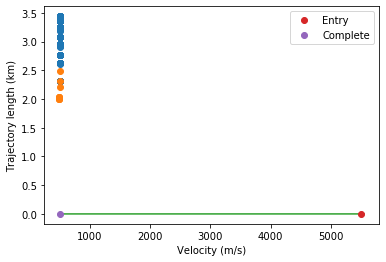

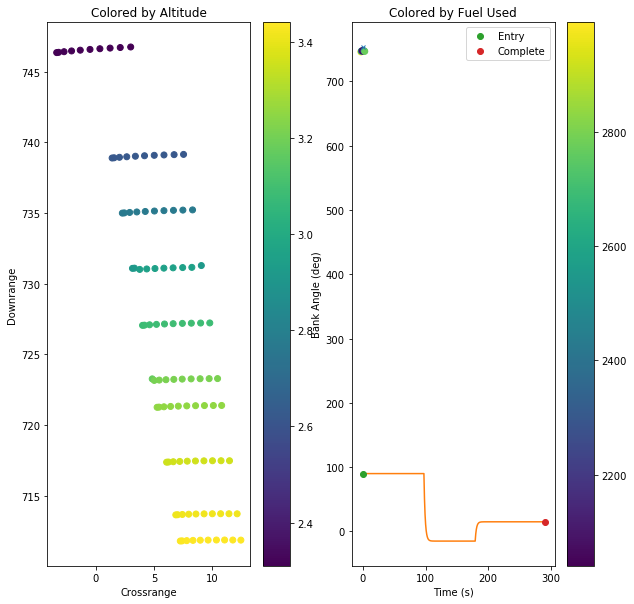

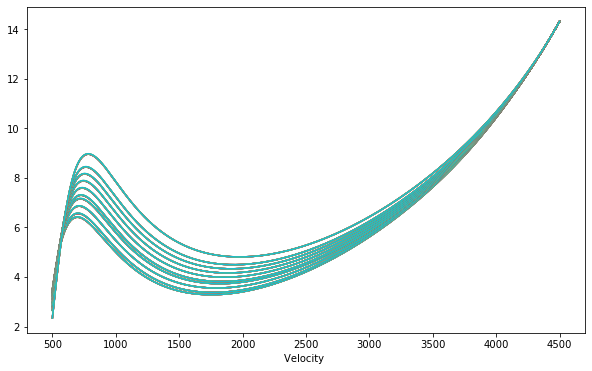

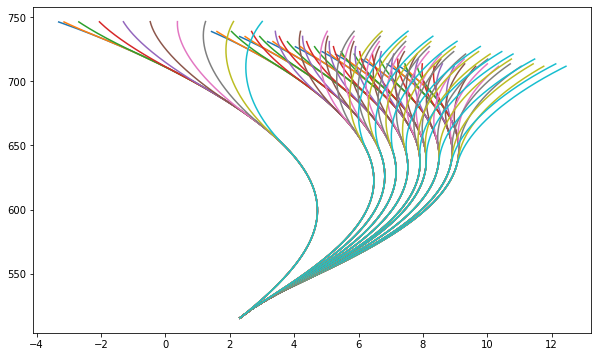

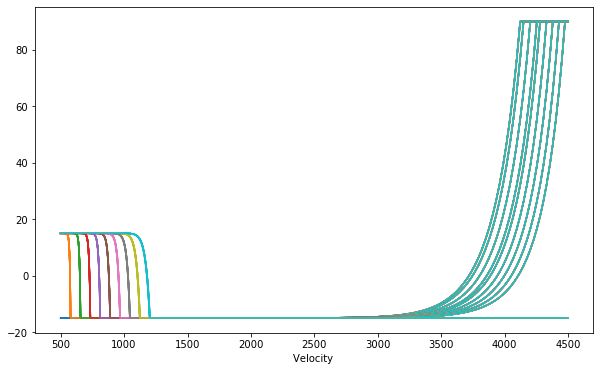

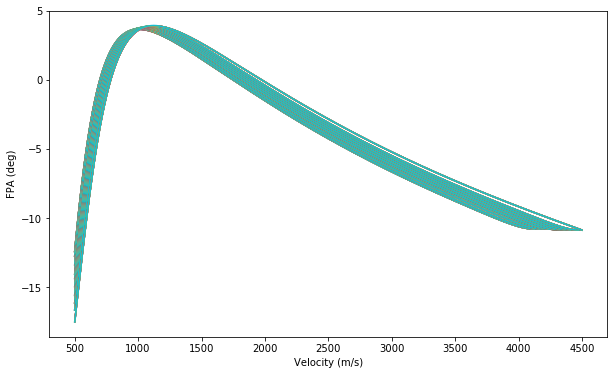

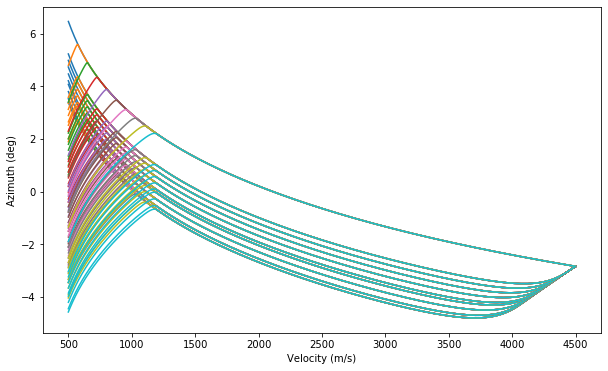

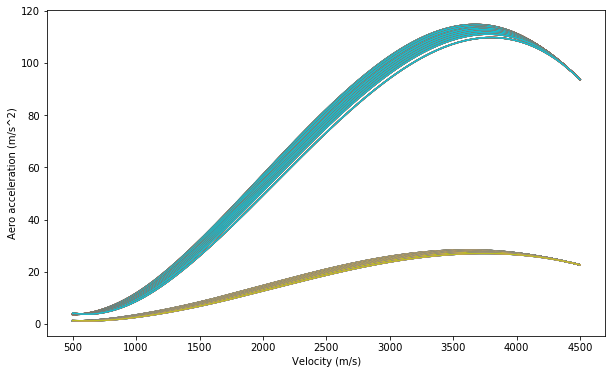

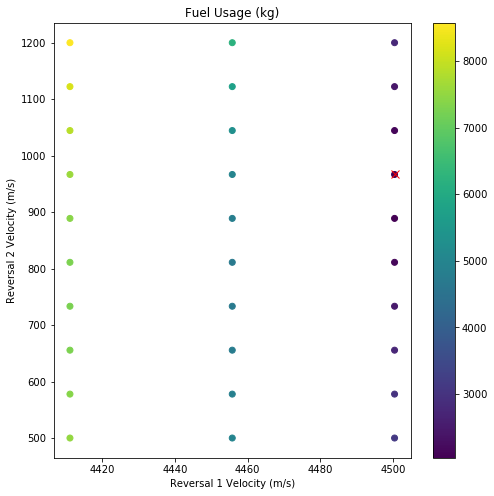

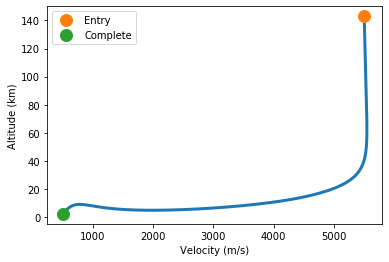

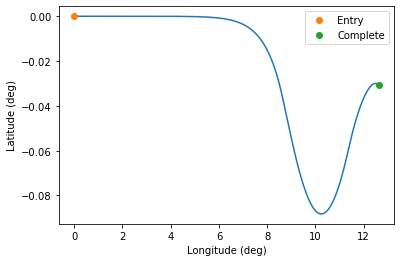

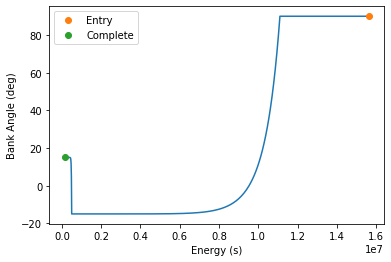

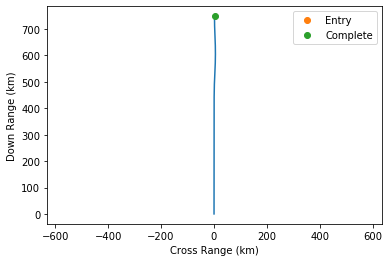

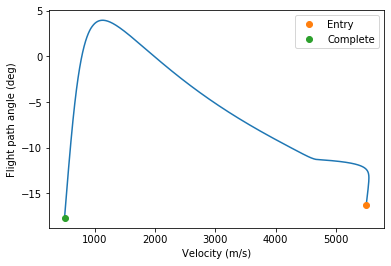

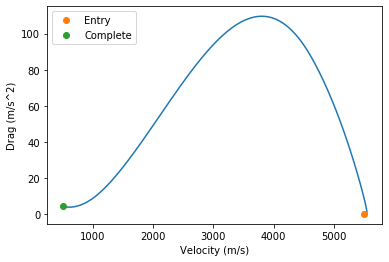

In [20]:
def constant_controller(banks):
    """ Vectorized constant bank angle control
    Could probably be removed since fixed controller with v_reverse set very high or very low will produce the same result"""
    def _control(e,x,l,d):
        return banks
    return _control

def fixed_controller(bank, v_reverse):
    """ This version requires v_reverse to be the same length as the state
    This is so that we can quickly determine where a reversal should go 
    
    """
    def _control(e,x,l,d):
        sigma = np.ones_like(x[0])*bank
        sigma[np.less_equal(x[3], v_reverse)] *= -1 
        return sigma
    return _control

def reversal_controller(bank, v_reverse):
    """ This version requires v_reverse to be scalar
    This is for generating a reference trajectory in a single trajectory simulation
    
    """
    def _control(v):
        sigma = bank
        if v < v_reverse:
            sigma = -bank 
        return sigma
    return _control

def switch_controller(v_reverse, vectorized):
    b1 = 90
    b2 = 15
    if vectorized:
        def _control(e,x,l,d):
            v = x[3]
            sigma = np.radians(b1)*np.ones_like(e)
            sigma[np.less_equal(v, v_reverse[0])] = -np.radians(b2)
            sigma[np.less_equal(v, v_reverse[1])] = np.radians(b2)
            return sigma
    else:
        def _control(v):
            sigma = np.radians(b1)
            if v <= v_reverse[0]:
                sigma = -np.radians(b2)
            if v <= v_reverse[1]:
                sigma = np.radians(b2)
            return sigma
    return _control


class MCController:
    
    """ From current state, integrate a profile forward in a vectorized manner, 
    select the best one -  requires both determining the best/correct endpoint of a given trajectory, 
    as well as the best trajectories from the set and interpolating 
    
    Given that we will have a target altitude at the end of the deceleration phase (site altitude + margin)
    An altitude trigger set to that altitude makes sense, as the ignition point is guaranteed to be earlier 
    
    """
    
    def __init__(self, N, target=None, srpdata=None, update_function=None, debug=False):
        
        self.banksign = 1 
        self.debug = debug 
        self.N = N
        self.target = target 
        self.update = update_function
        self.vmc = VMC()
        self.vmc.null_sample(np.product(N)) # This is because we're using N samples per param, + the zero case where we don't "need" reversals 
        
        if srpdata is None and target is not None:
            self.srpdata = SRPData(os.path.join(os.getcwd(), "data\\FuelOptimal\\srp_35400.mat"), min_alt=0, max_fuel=8000)
            self.srpdata.build(20000, {'kernel': 'cubic'})    
        else:
            self.srpdata = srpdata 
            
        self.vmc.set_trigger(velocity_trigger(500))
        self.control_params = []  # These are actual the whole space of control params over which we are searching for the optimum 
#         init_params = (np.radians(40.3), 2809.1)
        init_params = [4693.103448275862, 955.5555555555555]
        self.history = {"n_updates": 0,  "params": [init_params], "n_reversals": 0 ,"fuel": [1520], "state": []}
        self.set_profile(self.history['params'][0])
        
        # Construct a simulation here for use in predictions
        Vf = 400 
        self.sim = Simulation(cycle=Cycle(0.1), output=False, use_da=False, **EntrySim(Vf=Vf), )

    def plot_history(self):
        h = self.history
        update = list(range(h['n_updates']+1))
        
        plt.figure(figsize=(8,14))
        plt.subplot(2, 1, 1)
        plt.plot(update, h['fuel'], 'o-')
        plt.ylabel("Estimated Optimal Fuel Required (kg)")
        plt.subplot(2, 1, 2)
        plt.plot(update, h['params'], 'o-')
        plt.xlabel("Update #")
        plt.ylabel("Optimal Parameters")
        
        
    def predict(self, state):
        # A method that integrates forward from the current state and gets the predicted fuel performance
        # The update method can utilize this to check if an update should occur (if the discrepancy is large etc)
        
        def ref_profile(velocity, **args):
            sigma = self.profile(velocity)
            return sigma 
        self.sim.run(state, [ref_profile], TimeConstant=2.0) # Make sure the time constant matches what we use in the VMC in __call__
        mf = self.srp_trim(self.sim.history)
        return mf 
        
    def srp_trim(self, traj):
        vmax = 1000 
        v = traj[:,3]
        k = v < vmax
        rtg,cr = range_from_entry(traj[k], self.target.coordinates())
        x_srp = srp_from_entry(traj[k], rtg, cr, target_alt=self.target.altitude).T # 6 x N
        h = x_srp[2]
        hmin = self.srpdata.hmin
        high = h > hmin
        if np.any(high):
            m_srp = self.srpdata(x_srp.T[high])
            I = np.argmin(m_srp)
#             self.mc_srp['traj'].append(np.concatenate((traj[np.invert(k)], traj[k][high][:I])))
#             self.mc_srp['terminal_state'].append(traj[k][high][I])
#             self.mc_srp['fuel'].append(m_srp[I])
#             self.mc_srp['ignition_state'].append(x_srp[:,high][:,I]) # may need a transpose
            return m_srp[I]
        else: # No suitable state was found
            return 100000


    def set_profile(self, params):
#         self.profile = reversal_controller(*params)
        self.profile = switch_controller(params, False)
        
    def set_control_params(self, velocity,):
        if 0: # reversal controller 
            bank_range = np.radians([30, 45])
            reversal_range = [min(velocity-100, 2500), min(velocity, 3400)] # The current velocity is the upper bound on when a reversal could occur, the lower bound is fixed until below the lower bound 
            B,Vr = boxgrid([bank_range, reversal_range], self.N, interior=True).T
            # 0 might be the best choice but then we don't need to check all the different reversals 
#             B = np.append(B, 0)
#             Vr = np.append(Vr, reversal_range[0])

            self.control_params = (B,Vr)
            self.vmc.control = fixed_controller(B, Vr)
        else:
            
            V1,V2 = boxgrid([[min(4600, velocity-400), min(5000, velocity+2)], [500, 1200]], self.N, interior=True).T  # Allowing 0 set of points above the current velocity means no 90 deg arc 
#             plt.figure()
#             plt.hist(V1)
#             plt.figure()
#             plt.hist(V2)
            self.control_params = (V1,V2)
            self.vmc.control = switch_controller([V1,V2], True)
        

    def __call__(self, current_state, **kwargs):
        """Maintain a bank angle profile
            Replan either at fixed intervals or at certain variables 
        
        """
        # Determine the current bank angle from the profile
        v = current_state[3]
        
        if self.update(self.history, current_state, **kwargs):
            if self.debug:
                print("Update triggered")

            self.set_control_params(current_state[3],)
            self.vmc.run(current_state, save=False, stepsize=0.25, time_constant=2.0)
            if self.debug:
                self.vmc.plot()
                self.vmc.plot_trajectories()
                
            if self.target is not None:
                self.vmc.srp_trim(self.srpdata, self.target, vmax=700)
                if self.debug:
                    self.vmc.plot_srp(max_fuel_use=3000)
                fuel = np.array(self.vmc.mc_srp['fuel'])
                keep =  fuel < 10000
                if np.any(keep):
                    opt = np.argmin(fuel)
                    params = self.control_params[0][opt], self.control_params[1][opt]
#                     params = self.control_params[opt]
                    self.set_profile(params)
                    self.history['n_updates'] += 1 
                    self.history['params'].append(params)
                    self.history['fuel'].append(fuel[opt])
                    self.history['state'].append(current_state)

                    if 1: # diagnostics 
                        print("Target DR = {:.1f} km".format(self.target.longitude*3397))
#                         print("- Optimum: {:.1f} kg at {:.1f} deg, reversal at {:.1f}".format(fuel[opt], np.degrees(self.control_params[0][opt]), self.control_params[1][opt]))
                        print("- Optimum: {:.1f} kg, {}".format(fuel[opt], params))
                        mf = self.predict(current_state)   
                        print("Predicted fuel consumption from single integration: {:.1f} kg".format(mf))
                        print("Ignition State:")
                        for state in self.vmc.mc_srp['ignition_state'][opt]:
                            print("{:.1f}".format(state))
                            
                    if self.debug:
#                         plt.figure()
#                         plt.scatter(np.degrees(self.control_params[0][keep]), self.control_params[1][keep], c=fuel[keep])
#                         plt.xlabel("Bank Angle (deg)")
#                         plt.ylabel("Reversal Velocity (m/s)")
#                         plt.title("Fuel Usage (kg)")
#                         plt.colorbar()
                        
                        plt.figure(figsize=(8,8))
                        plt.scatter(self.control_params[0][keep], self.control_params[1][keep], c=fuel[keep])
                        plt.plot(self.control_params[0][opt], self.control_params[1][opt], 'rx', markersize=8)
                        plt.xlabel("Reversal 1 Velocity (m/s)")
                        plt.ylabel("Reversal 2 Velocity (m/s)")
                        plt.title("Fuel Usage (kg)")
                        plt.colorbar()

#                         plt.figure()
#                         plt.scatter(self.control_params[keep], fuel[keep])
#                         plt.xlabel("Reversal Velocity (m/s)")
#                         plt.ylabel("Fuel Usage (kg)")
#                         plt.colorbar()
                        
            # Whether or not we just updated the profile, call it!
        bank = self.profile(v)

        # Capture the number of reversals 
        s = np.sign(bank)
        if s == 0:
            s = 1
        if not s == self.banksign:
            self.history['n_reversals'] += 1
            self.banksign =  s
        return bank 

x0 = InitialState(vehicle='heavy', fpa=np.radians(-16.3))    
target = Target(0, 753.7/3397, 0)

# This construction is just to prevent rebuilding the SRP data over and over 
try:
    dir(srpdata)
except NameError:
    srpdata = SRPData(os.path.join(os.getcwd(), "data\\FuelOptimal\\srp_35400.mat"), min_alt=0, max_fuel=8000)
    srpdata.build(20000, rbf_kw={'kernel': 'cubic'})
    

def update_rule(history, state, **kwargs):
    r,th,ph,v,gamma,psi,m = state
    
    Vr = [4500, 3000, 1500] # The velocities at which to update 
    # Put a high velocity to trigger an initial planning, but in general we should start with a nominal stored already, and not update till later 
    
    for i, vr in enumerate(Vr):
        return (history['n_updates'] == i and v <= vr)
    
    
mcc = MCController(N=[10, 10], target=target, srpdata=srpdata, update_function=update_rule, debug=True)
# mcc = MCController(N=50, target=target, srpdata=srpdata, update_function=update_rule, debug=True)

Vi = 500
sim = Simulation(cycle=Cycle(0.1), output=True, use_da=False, **EntrySim(Vf=Vi), )
# sim.run(x0, [lambda **d: np.radians(90)])
# sim.run(x0, [lambda velocity, **d: switch_controller([4693.103448275862, 955.5555555555555], False)(velocity)], TimeConstant=2)
# sim.plot()
# xi = sim.history[-1]

sim.run(x0, [mcc], TimeConstant=2)
sim.plot()
# mcc(xi)
# mcc.plot_history()

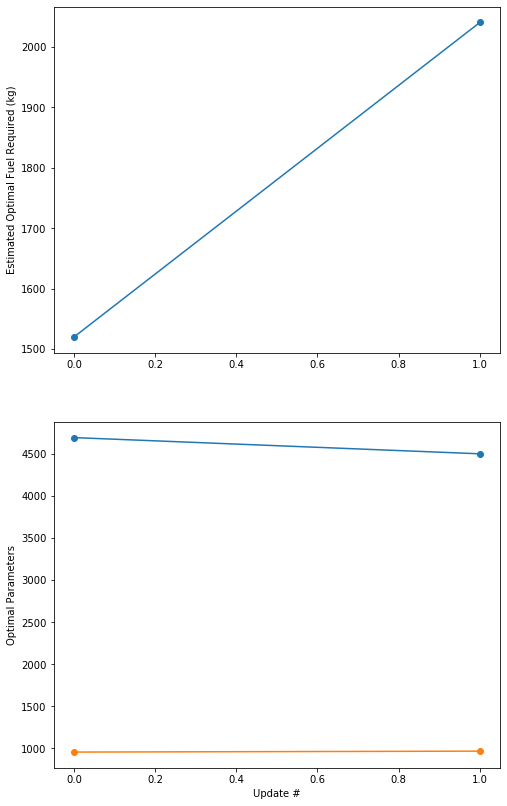

In [22]:
mcc.plot_history()

FPA = -16.3 deg

Site Altitude = 0 m

Target DR = 753.7 km

- Optimum Constant + Reversal: 1683.6 kg, (0.7105983383119769, 2885.714285714286)
- Optimum Two Switch (90, -15, 15): 1517.8 kg, (4693.103448275862, 955.5555555555555)
- Optimum Two Switch (90, -15, 0): 1700+, for some reason couldn't perform well! 

Conclusion: A "high elevation" type profile outperformed a constant profile by about 10%.
The switch times have nicely separated effects: the first switch from a high bank to near-zero sets the altitude and downrange performance. The second switch, is essentially only a sign change without changning lift, thus its purpose is to align the heading for ignition.

## Fuel optimal solutions for fixed target, EFPA, and site altitude

FPA = -20.8 deg, 
Site Altitude = -3500 m

Target DR = 550.0 km
- Optimum: 1471.6 kg at 7.7 deg, reversal at 2437.5

Target DR = 540.0 km
- Optimum: 1443.2 kg at 18.3 deg, reversal at 2437.5

Target DR = 530 km
- Optimum: 1773.1 kg at 26.3 deg, reversal at 2437.5

Target DR = 525 km
- Optimum: 1831.5 kg at 28.9 deg, reversal at 2590.6

Target DR = 520 km
- Optimum: 1889.5 kg at 31.6 deg, reversal at 2590.6


## Vectorized Apollo Implementation

In [ ]:
def predict_error(IV, D, r_dot, rtogo, V, ref):
#     print("\nIV: {}".format(IV))
# #     print("V = {}".format(V))
#     print("Drag accel = {}, ref = {}".format(D, ref['DREF'](IV)))
#     print("Alt Rate: {} m/s, ref = {} m/s".format(r_dot, ref['RTOGO'](IV)))
#     print("RTG: {}, ref = {} \n".format(rtogo, ref['RTOGO'](IV)))
#     print("  Drag Contribution to predicted error: {}".format(ref['F1'](IV)*(D-ref['DREF'](IV))))
#     print("  Rdot Contribution to predicted error: {}".format(ref['F2'](IV)*(r_dot-ref['RDTREF'](IV))))
#     print("  Rtogo Contribution to predicted error: {}".format(-ref['F4'](IV)*(rtogo - ref['RTOGO'](IV))))
#     print("  Vel Contribution to predicted error: {}".format(ref['F5'](IV)*(V - ref['VREF'](IV))))
    return ref['F1'](IV)*(D-ref['DREF'](IV)) + ref['F2'](IV)*(r_dot-ref['RDTREF'](IV)) - ref['F4'](IV)*(rtogo - ref['RTOGO'](IV)) + ref['F5'](IV)*(V - ref['VREF'](IV))

def LoD_command(IV, error, ref):
    du = ref['F3'](IV)
    du[du == 0] = 1 
    return ref['LOD'](IV) - ref['K']*error/du
    
def bank_command(LoD, LoD_com, minimum=0, maximum=1):
    return np.arccos(np.clip(LoD_com/LoD, minimum, maximum))

def energy_iv(energy, *args, **kwargs):
    return energy 

def velocity_iv(energy, state, *args, **kwargs):
    return state[3]

def rtg_iv(rtogo, *args, **kwargs):
    return rtogo

def experimental_iv(energy, state, rtogo, *args, **kwargs):
    return (state[3]/5000)**0.5
#     return state[3]*rtogo/1000/1000

def controller(target, reference, one_sided=False, debug=False, bank_lims=[0,90], lateral_guidance=None):
    """ Vectorized Apollo Implementation 

    Reference is a dictionary with reference states, influence coefficients, overcontrol gain, and planet model, required for computing distances to the target 
    Target is a target class 
    independent_variable is a function that returns the appropriate variable  


    """
    def _controller(energy, state, lift, drag):

        r, lon, lat, v, fpa, azimuth, mass =  state
        
            
        rdot = v*np.sin(fpa)
#         rtogo, _ = reference['planet'].range(lon, lat, azimuth, *target, km=False) # is this the correct range to go computation?
        rtogo, crossrange = reference['planet'].range(lon, -lat, 0, *target.coordinates(), km=False) # definitely want to use this for crossrange computation, but we need to negate 
    
        iv = reference['IV_function'](energy=energy, state=state, target=target, rtogo=rtogo)
        error = predict_error(iv, drag, rdot, rtogo, v, reference)

        error[drag < 2] = 0 # open loop reference till drag condition is met 
        
        # Experimental one-sided control 
        if one_sided == 1:  # keep positive errors 
            error[error<=0] = 0
            
        if one_sided == -1:
            error[error>=0] = 0 # keep negative errors only 
                
        LoDc = LoD_command(iv, error, reference)
        if lateral_guidance is None:
            # One form of lateral control -  use the reference bank angle sign 
            sign = np.sign(reference['U'](iv))
            sign[sign==0] = 1
        else:
            # Alternatively, use a provided lateral guidance 
            sign = lateral_guidance(state, crossrange)
        
        sigma = np.clip(bank_command(lift/drag, LoDc), *np.radians(bank_lims))*sign
        if debug:
            print("DR = {}, CR = {} km".format(rtogo/1000, crossrange/1000))
            print("Predicted Error = {}".format(error/1000))
            print("Bank Cmd = {} deg".format(np.degrees(sigma)))
#             print("Nan Control, States= {}".format(state.T[np.isnan(sigma)]))
        
        
        return sigma 
    return _controller
    

In [ ]:
def gains(traj, L0, edlModel, independent_variable=velocity_iv, use_drag_rate=False):
    """ Determines the sensitivities based on a reference trajectory 
    
        traj should be a dataframe or array from sim output 
        L0 is the initial condition for the adjoints at the terminal state
        L0 order is [s, v, gamma, h, u]
    
    """ 
    edl = edlModel   
    w = edl.planet.omega
    
#     traj = sim.output
    time = traj[:,0]
    energy = traj[:,1]
    bank = np.radians(traj[:,2])
    radius = traj[:,4]
    lon = np.radians(traj[:,5])
    lat = np.radians(traj[:,6])
    vel = traj[:,7]
    fpa = np.radians(traj[:,8])
    azi = np.radians(traj[:,9])
    traj[0,10] = 0 # fix that stupid range error at 0 distance 
    rtgo = traj[-1,10]-traj[:,10]
#     print(rtgo)
#     print(np.any(np.isnan(rtgo)))
#     rtgo[np.isnan(rtgo)] = 0 
    lift = traj[:,12]
    drag = traj[:,13]
    
    lod = lift*np.cos(bank)/drag
    altrate = vel*np.sin(fpa)
    
    # Prep for backwards integration of adjoints
#     l1 = 1.0                  # s
#     l2 = 0.0                  # v
#     l3 = 0.0                  # gamma
#     # l3 = (radius[-1]-edl.planet.radius)*sin(fpa[-1])**2     # gamma
#     l4 = -1.0/tan(fpa[-1])    # h
#     l5 = 0.0                  # u
    
    l1,l2,l3,l4,l5 = L0 
    L = [[l1,l2,l3,l4,l5]]
    
    hs = edl.planet.scaleHeight
    akm = 1000.0

    tfine = np.linspace(time[-1], time[0], 10000) # backwards
    dt = tfine[-2]
    rtogo = interp1d(time, rtgo*1000)(tfine) 
    vref  = interp1d(time, vel)(tfine)
    eref  = interp1d(time, energy)(tfine)
    rref  = interp1d(time, radius)(tfine)
    rdtref = interp1d(time, altrate)(tfine)
    dref = interp1d(time, drag)(tfine)
    ddtref = np.append(np.diff(dref)/np.diff(tfine), 0)
    lodref = interp1d(time, lod)(tfine)
    gamma = interp1d(time, fpa)(tfine)

    g = edl.gravity(rref)

    liftv = lodref*dref
    sg = np.sin(gamma)
    cg = np.cos(gamma)
    c1 = liftv/vref**2 + cg/rref + g*cg/vref**2
    c2 = (vref/rref - g/vref)*sg
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    uref = interp1d(time, bank)(tfine)
    
    for i in range(tfine.shape[0]):
        
        f1.append(-hs/dref[i]*l4) 
        if use_drag_rate:
            f2.append(l3/(-cg[i]*dref[i]*(vref[i]/hs + 2*g/vref[i])))
        else:
            f2.append(l3/(vref[i]*cg[i]))
        f3.append(l5)
        f4.append(l1)
        f5.append(l2)
        
        
        # Leave these for posterity 
#         dl1 = 0
#         dl2 = -cg[i]*l1 + 2*dref[i]/vref[i]*l2 - c1[i]*l3 - sg[i]*l4                        
#         dl3 = vref[i]*sg[i]*l1 + g[i]*cg[i]*l2 + c2[i]*l3 - vref[i]*cg[i]*l4
#         dl4 = -dref[i]/hs*l2 + l3*(liftv[i]/vref[i]/hs + vref[i]*cg[i]/rref[i]**2) # original 
#         dl4 = (-dref[i]/hs - 2*g[i]/rref[i])*l2 + l3*(liftv[i]/vref[i]/hs + vref[i]*cg[i]/rref[i]**2 - cg[i]*2*g[i]/rref[i]/vref[i])  # my mod 
#         dl5 = -dref[i]/vref[i]*l3
        
        # Try to find a sign error?
        dl1 = 0
        dl2 =        -cg[i]*l1 + 2*dref[i]/vref[i]*l2 - c1[i]*l3 - sg[i]*l4                        
        dl3 = vref[i]*sg[i]*l1 +        g[i]*cg[i]*l2 + c2[i]*l3 - vref[i]*cg[i]*l4
        dl4 =                          -dref[i]/hs*l2 +       l3*(liftv[i]/vref[i]/hs + vref[i]*cg[i]/rref[i]**2) 
        dl5 =                                -dref[i]/vref[i]*l3
    
        l1 -= dt*dl1
        l2 -= dt*dl2
        l3 -= dt*dl3
        l4 -= dt*dl4
        l5 -= dt*dl5
        L.append([l1, l2, l3, l4, l5])  # This is just to keep them for plotting

    # build the output dictionary
    vi = independent_variable(energy=eref, rtogo=rtogo, state=np.array([rref, interp1d(time, lon)(tfine), interp1d(time, lat)(tfine), vref, gamma, interp1d(time, azi)(tfine)]))
       
#     plt.plot(vref, vi)
#     plt.xlabel('velocity')
#     plt.ylabel('independent variable ')
#     plt.show()
#     plt.plot(np.diff(vi))
#     plt.show()

    # Monotonicity check needs to be done here:
    def is_strictly_increasing(a):
        return np.all(a[1:] > a[:-1])
    def is_strictly_decreasing(a):
        return is_strictly_increasing(-a)
    
    increasing = is_strictly_increasing(vi)
    decreasing = is_strictly_decreasing(vi)
    monotonic = (increasing or decreasing)
    if not monotonic: # whatever we have, it isn't strictly monotonic
        if vi[0] < vi[-1]: # a decreasing IV because vi is in backwards order, same as the adjoint integration 
            print("Nonmonontonic decreasing variable - storing only from maximum downward")
            iv = np.argmax(vi)
        else:
            assert False, 'increasing IV not supported unless strictly monotonic'
#             iv = np.argmin(vi)

        vi = vi[:iv]
        f1 = np.array(f1)[:iv]
        f2 = np.array(f2)[:iv]
        f4 = np.array(f4)[:iv]
        f5 = np.array(f5)[:iv]
        f3 = np.array(f3)[:iv]
        
        rtogo = rtogo[:iv]
        rdtref = rdtref[:iv]
        dref = dref[:iv]
        vref = vref[:iv]
        ddtref = ddtref[:iv]
        lodref = lodref[:iv]
        uref = uref[:iv]
        L = np.array(L)[:iv]
        iv = iv-1
    else:
        iv = -1
        f1 = np.array(f1)
        f2 = np.array(f2)
        f4 = np.array(f4)
        f5 = np.array(f5)
        f3 = np.array(f3)
        L = np.array(L)[:-1]

    
    nzi = f3.nonzero()   

    data = { 'F1'     : interp1d(vi, f1,          fill_value=(f1[0], f1[-1]),         assume_sorted=True, bounds_error=False),  # Drag gain 
             'F2'     : interp1d(vi, f2,          fill_value=(f2[0], f2[-1]),         assume_sorted=True, bounds_error=False),  # Altitude rate (or drag rate) gain
             'F3'     : interp1d(vi[nzi], f3[nzi],fill_value=(f3[0], f3[-1]),         assume_sorted=True, bounds_error=False),  # Control gain
             'F4'     : interp1d(vi, f4,          fill_value=(f4[0], f4[-1]),         assume_sorted=True, bounds_error=False),  # Range gain    
             'F5'     : interp1d(vi, f5,          fill_value=(f5[0], f5[-1]),         assume_sorted=True, bounds_error=False),  # Velocity gain

             'RTOGO'  : interp1d(vi, rtogo,  fill_value=(rtogo[0], rtogo[iv]),   assume_sorted=True, bounds_error=False),
             'RDTREF' : interp1d(vi, rdtref, fill_value=(rdtref[0], rdtref[iv]), assume_sorted=True, bounds_error=False),
             'DREF'   : interp1d(vi, dref,   fill_value=(dref[0], dref[iv]),     assume_sorted=True, bounds_error=False),
             'VREF'   : interp1d(vi, vref,   fill_value=(vref[0], vref[iv]),     assume_sorted=True, bounds_error=False),
             'DDTREF' : interp1d(vi, ddtref, fill_value=(ddtref[0], ddtref[iv]), assume_sorted=True, bounds_error=False),
             'LOD'    : interp1d(vi, lodref, fill_value=(lodref[0], lodref[iv]), assume_sorted=True, bounds_error=False),
             'U'      : interp1d(vi, uref,   fill_value=(uref[0], uref[iv]),     assume_sorted=True, bounds_error=False),
             'K'      : 1,
             'L'      : L,  # These last two are not used by the controller 
             'IV'     : vi,
            'IV_function': independent_variable,
            }
             
    return data

## Lateral Control

In [13]:
def CrossrangeDeadband(c0, c1, debug=False):
    
    def _controller(state, cr, *args, **kwargs):
        v = state[3]
        heading = state[5]
#         print("\nCrossrange: ")
#         print(cr)

        reverse = np.abs(cr) >= (c0 + v*c1) # outside the deadband 

        S = -np.sign(heading)
        S[S==0] = 1
        S[reverse] = -np.sign(cr[reverse])
        if debug:
            print("\nCurrent Sign: ")
            print(-np.sign(heading))        
            print("Deadband:")
            print(reverse)        
            print("Commanded sign:")
            print(S)
        return S
    return _controller


class HeadingDeadband:

    def __init__(self, c0, c1):
        
        self.c = [c0, c1]
        self.command = None
        
    def reset(self):
        self.command = None 
        
    def __call__(self, state, cr, *args, **kwargs):
        # state = n X N 
        
        v = state[3]
        heading = state[5]
        
#         reverse = np.abs(heading) >= (self.c[0] + self.c[1]*v)
        pos = heading >= (self.c[0] + self.c[1]*v)
        neg = heading <= -(self.c[0] + self.c[1]*v)

        # basically, just update the command if pos or neg is new
        # so check pos/neg current against previous command of oppposite sign, 
        
        if self.command is None: # initialization 
            self.command = np.zeros_like(v)
            self.command[pos] = 1
            self.command[neg] = -1 
        else:
            pos = np.logical_and(self.command <= 0, pos) # rather than check == -1, we use <= 0 to allow for unitialized cases
            neg = np.logical_and(self.command >= 0, neg)
            
            # This attempts to prevent early reversals when we havent overshot the crossrange yet 
            CR_LIM = 0.5
            pos = np.logical_and(pos, cr <= CR_LIM)
            neg = np.logical_and(neg, cr >= -CR_LIM)
#             no_update = np.invert(np.logical_or(pos, neg))
            self.command[pos] =  1
            self.command[neg] = -1
            
        S = self.command.copy()
        S[S==0] = 1 
        return S 

def ConstantBankWithLateralGuidance(bank_angles, lateral_guidance):
    def controller(e,x,l,d):
        cr = -x[2]*3397 
        sign = lateral_guidance(x, cr)
        
        return sign*bank_angles 
    return controller 




In [ ]:
# demonstrate with constant bank angles 
N = 1000
lateral = CrossrangeDeadband(0., 3.5/5000)
# lateral = HeadingDeadband(np.radians(0.5), np.radians(1)/5000)
# lateral = lambda state,cr: np.ones_like(cr)
# constant_guidance = ConstantBankWithLateralGuidance(np.radians(np.linspace(15, 45, N)), lateral)
constant_guidance = ConstantBankWithLateralGuidance(np.radians(15), lateral)

mc = VMC()
# mc.null_sample(N)
mc.sample(N)

mc.control = constant_guidance
Vf = 600
mc.set_trigger(velocity_trigger(Vf))

# mc.run(x0, save=False, stepsize=1) # for single initial condition 

X0 = mc.sample_state(x0, np.diag([1, 1/3397, 1/3397, 1, np.radians(0.25/3), np.radians(0.25/3), 0.01])**2, N)
mc.run(X0, save=False, stepsize=1)

In [ ]:
mc.plot()

In [ ]:
mc.plot_trajectories()

## Entry Profile Parametrization

In [ ]:
# Create a vectorized controller 

def f_vector(v, vshift):
    out = v/vshift 
    out[v > vshift] = 1
    
    return out 

def profile(Vs, shift, V0):
    return lambda E,X,L,D: np.cos(X[3]*Vs + shift)*np.pi/2 * f_vector(X[3],V0)

x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))
Vf = 500

V = np.linspace(x0[3], Vf)
param = []
for Vs in np.linspace(0.0, 0.005, 100):
# for Vs in [0]:
    for Vr in [ 2500,]:
        for shift in np.linspace(0, 2*np.pi, 37): 
            param.append((Vs, shift, Vr))
        
param = np.array(param)
print(np.shape(param))

For a constant bank angle and a single reversal, there is a single velocity that achieves zero crossrange at a specific velocity, and also a single velocity that achieves a minimal fuel consumption 

In [ ]:
# N = param.shape[0]
N = 10
mc = VMC()
mc.sample(N)
mc.samples *= 0

# mc.control = profile(*param.T)
banks = [5, 15, 25, 45, 65, 80]
reverse = [2815, 2865, 2962, 3215., 3455., 3608.]
rev = interp1d(banks, reverse)

Vr = np.linspace(3600, 3610, N)
sigma = 35
mc.control = fixed_controller(np.radians(sigma), Vr)
mc.set_trigger(velocity_trigger(Vf))
# mc.set_trigger(altitude_trigger(4.6)) # 4.6 km is the optimal altitude at 500 m/s with efpa -20.8. The final velocity is basically a measure of the suboptimality wrt fuel consumption 

mc.run(x0, save=False, stepsize=0.05)

In [ ]:
plt.plot(Vr, -mc.xf[:,2]*3397)

In [ ]:
mc.plot()
plt.show()

In [ ]:
r,lon,lat,v,fpa,psi,m = mc.xf.T

h = (r-mc.model.planet.radius)/1000
dr = mc.model.planet.radius*lon/1000
cr = -mc.model.planet.radius*lat/1000

keep = np.abs(cr) <= 0.2
i = np.argmax(h[keep])
print("Max altitude at Vf = {:.1f} m/s with less than 200 m crossrange = {:.2f}".format(v[keep][i],np.max(h[keep])))
opt = param[keep][i]
print("From profile with Vs = {}, shift = {}, Vr = {}".format(*opt))
print("DR = {:.1f} km".format(dr[keep][i]))
plt.plot(V, profile_plot(*opt)(V))
plt.show()

In [ ]:
plt.figure(3)
plt.plot(v[keep], h[keep],'o')
plt.xlabel('Velocity ')
plt.ylabel('Altitude ')

plt.figure(4)
plt.scatter(cr[keep], dr[keep], c=h[keep])
plt.xlabel('Crossrange')
plt.ylabel('Downrange')

plt.title("Altitude")
plt.colorbar()
plt.show()

# Footprint Sensitivity to parametric uncertainty 

 
Generating 500 samples...
(4, 500)
 
Running Monte Carlo...
E0 15634313.6
Ef 0.0
energy depleted 
MC shape
(271, 7, 500)
(270, 1, 500)
(270, 2, 500)
Terminal state shape: 
(500, 7)
Monte Carlo complete, time elapsed = 5.7 s.
 
Running Monte Carlo...
E0 15634313.6
Ef 0.0
energy depleted 
MC shape
(278, 7, 500)
(277, 1, 500)
(277, 2, 500)
Terminal state shape: 
(500, 7)
Monte Carlo complete, time elapsed = 5.9 s.
 
Running Monte Carlo...
E0 15634313.6
Ef 0.0


E:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:320: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


energy depleted 
MC shape
(263, 7, 500)
(262, 1, 500)
(262, 2, 500)
Terminal state shape: 
(500, 7)
Monte Carlo complete, time elapsed = 5.6 s.


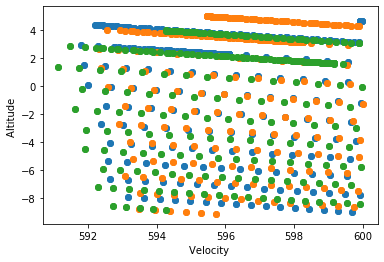

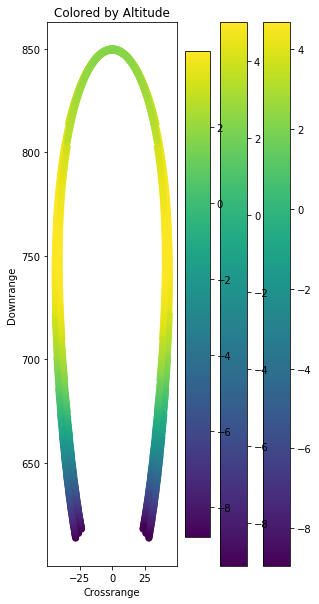

In [33]:
def cartesian_product(x, y):
    return np.array([np.tile(x, len(y)), np.repeat(y, len(x))])

interior = False

N = 500
B0 = np.linspace(-np.pi/2, np.pi/2, N)
Vr = np.linspace(600, 4500, N)

if interior:
    Nsamples = N**2 + N
    B,Vr = cartesian_product(B0,Vr)
    B = np.concatenate([B0,B], axis=0)
    Vr = np.concatenate([np.zeros_like(B0), Vr])
else:
    Nsamples = N
    B = B0
    Vr = np.zeros_like(B)

constant_guidance = fixed_controller(B, Vr)

mc = VMC()
mc.null_sample(Nsamples)
mc.control = constant_guidance
Vf = 600
mc.set_trigger(velocity_trigger(Vf))
print(mc.samples.shape)
mc.run(x0, save=False, stepsize=1)
mc.plot()
# Cd, CL, rho0, hs
# for i in range(4):
for i in [3]:
    mc.samples = np.zeros((4, Nsamples))
    mc.samples[i] = 0.1

    mc.run(x0, save=False, stepsize=1)
    mc.plot()
    
#     mc.samples = np.zeros((4, Nsamples))
    mc.samples[i] = -0.1

    mc.run(x0, save=False, stepsize=1)
    mc.plot()

Notes: termination at fixed velocity

$\pm10\%$ drag variation
- $\pm 2$ km altitude variation
- $\pm75 $ km downrange; Slight asymmetry, lower drag produces slightly larger downrange variation than higher drag shortens it.

$\pm10\%$ lift variation
- little altitude variation
- $\pm75 $ km downrange; Slight asymmetry, very similar to drag effects 

$\pm10\%\,\rho_0$  variation
- $\pm 2$ km altitude variation
- very little downrange variation, perhaps because L/D is maintained 

$\pm10\%\,h_s$ variation
- surprisingly little effect on footprint or altitude performance 

## Determine Adjoints for different objectives 

In [ ]:
x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))

Vf = 500 
dasim = Simulation(cycle=Cycle(1), output=False, use_da=True, **EntrySim(Vf=Vf), )

names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 'm']
x0d = da.make(x0, names, 2)
u = gdual_double(0., 'u', 2)

def ref_profile(velocity, **args):
    sigma = reversal_controller(np.radians(35), rev(35))(da.const(velocity))
    sigma = sigma + np.sign(sigma)*u
    return sigma 


res = dasim.run(x0d, [ref_profile])
traj = da.const(dasim.df.values, True)

In [ ]:
# get stms for longitudinal states 
rows = [1, 3, 4, 0]
cols = rows + [-1] # get the derivs wrt controls too 
stm = [np.vstack([submatrix(da.jacobian(x, names+['u']), rows, cols), np.eye(5)[-1]]) for x in dasim.history]

# get adjoints 

dJdx = [dasim.edlModel.planet.radius, 0, 0, -1.0/np.tan(dasim.history[-1, 4].constant_cf), 0] # The apollo adjoints 
# dJdx = [dasim.edlModel.planet.radius, 0, 0, 0, 0] # The sensitivity to range alone  
dJdx = [0, 0, 0, 1, 0] # The sensitivity to altitude alone  
# dmdx = [-0.1*dasim.edlModel.planet.radius, 0.11, -760, -0.18, 0] # x = [s,v,fpa,h,u] for a nominal ignition at 500 m/s, -10 deg fpa, 5k downrange and 3 km altitude 
# dJdx = dmdx

stmi = [np.linalg.inv(st) for st in stm]
stmf = stm[-1]
C = np.dot(dJdx, stmf)
L = np.array([np.dot(C, si) for si in stmi])
sigma = da.const(dasim.control_history, True).T[0]
LoD = traj[:,12]/traj[:,13]
L[:,-1] *= -1/LoD/np.abs(np.sin(sigma))  # This converts from sensitivity in sigma to sensitivity of u = L/D cos(sigma)
L[:,0] /= dasim.edlModel.planet.radius # This converts from sensitivity in theta to sensitivity in range 

In [ ]:
dasim.history[-1, 4].constant_cf * 180/np.pi

## Generate a reference trajectory for use with Apollo

In [ ]:
x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))

Vf = 500 
sim = Simulation(cycle=Cycle(0.1), output=True, use_da=False, **EntrySim(Vf=Vf), )


def ref_profile(velocity, **args):
    sigma = reversal_controller(np.radians(45), rev(45)-7)(velocity)
    return sigma 


res = sim.run(x0, [ref_profile])
# sim.plot()

traj = da.const(sim.df.values, True)

# s v gamma h u 
# L0 = [-np.tan(dasim.history[-1, 4].constant_cf), 0, 0, 1, 0] # altitude with free tf, produces results identical to the apollo method despite different gains!! 
# L0 = [0, 0, 0, 1, 0]
# L0 = [-0.1, 0.5, -250, -0.18, 0] # mass
# L0 =  [1, 0, 0, -1.0/np.tan(sim.history[-1, 4]), 0] # apollo downrange with free tf 
L0 =  [1, 0, 0, 0, 0]

# apollo = gains(traj, L0, sim.edlModel, use_drag_rate=False, independent_variable=velocity_iv)
# apollo = gains(traj, L0, sim.edlModel, use_drag_rate=False, independent_variable=energy_iv)
apollo = gains(traj, L0, sim.edlModel, use_drag_rate=False, independent_variable=experimental_iv)

In [ ]:
# plot the adjoints from each method 
V = da.const(sim.history[:, 3])
imax = np.argmax(V)
nams = ['s','v','fpa', 'h', 'u']
# for name, adj_stm, adjoint in zip(nams, L.T, apollo['L'].T):
#     plt.figure(figsize=(8, 8))
#     plt.plot(V[imax:], adj_stm[imax:], '--',label='STM')
#     plt.plot(apollo['IV'], adjoint)

#     plt.title("sensitivity of terminal constraint to {}".format(name))
#     plt.legend()
# plt.show()

for name, adjoint in zip(nams, apollo['L'].T):
    plt.figure(figsize=(8, 8))
    plt.plot(apollo['IV'], adjoint)
    plt.title("sensitivity of terminal constraint to {}".format(name))
    plt.legend()
    
nams = ['D', 'hdot', ]
for name, adjoint in zip(nams, (apollo['F1'], apollo['F2'])):
    plt.figure(figsize=(8, 8))
    plt.plot(apollo['IV'], adjoint(apollo['IV']))
    plt.title("sensitivity of terminal constraint to {}".format(name))
    plt.legend()    
    
plt.show()


## Standard ETPC Monte Carlo

- Run nominal sim to fairly low velocity
- Determine ignition condition, optimal or otherwise 
- Create the apollo gains from the ignition condition
- Vectorized MC to past the nominal downrange/velocity
- Compute SRP cost from both the nominal downrange/velocity (if feasible) and from the optimal point along the trajectory 

In [ ]:
N = 5000

mc = VMC()

mc.sample(N)
# mc.null_sample(N)

lon = np.radians(traj[-1,5])
lat = np.radians(traj[-1,6])
target = Target(longitude=lon, latitude=lat)

apollo['K'] = 0
apollo['planet'] = sim.edlModel.planet
print("Target = {} deg".format(target.coordinates(degrees=True)))
print("DR = {:.1f}, CR = {:.2f}".format(*sim.edlModel.planet.range(np.radians(traj[0,5]), np.radians(traj[0,6]), np.radians(traj[0,9]),*target.coordinates(), km=True)))

lateral = CrossrangeDeadband(500., 1500./6000, debug=False)
# lateral = None 
mc.control = controller(target, apollo, debug=False, one_sided=0, bank_lims=[15,85], lateral_guidance=lateral)
# mc.control = open_loop(apollo)

mc.set_trigger(velocity_trigger(Vf))
# mc.set_trigger(altitude_trigger(4.6)) # 4.6 km is the optimal altitude at 500 m/s with efpa -20.8. The final velocity is basically a measure of the suboptimality wrt fuel consumption 

X0 = mc.sample_state(x0, np.diag([1, 1/3397, 1/3397, 1, np.radians(0.25/3), np.radians(0.25/3), 0.01])**2, N)
# X0[4] = x0[4] + np.radians([-0.1, 0, 0.1])*5
mc.run(X0, save=False, stepsize=1)
# mc.run(x0, save=False, stepsize=0.1)

In [ ]:
# srpdata = SRPData("E:\Documents\GitHub\Research\Matlab\srp_2625.mat", min_alt=2000)

In [ ]:
# mc.srp_trim(srpdata, (-3500, target[0]+2/3397, 0), vmax=3600, hmin=2000)


In [ ]:
mc.plot()
# mc.plot_srp()
plt.axis('square')
if N <= 2500:
    mc.plot_trajectories()

In [ ]:
m = np.mean(mc.xf, axis=0)
s = np.std(mc.xf, axis=0)

h = mc.model.altitude(m[0],km=True)
dr,cr = mc.model.planet.range(np.radians(traj[0,5]), np.radians(traj[0,6]), np.radians(traj[0,9]), *m[1:3], km=True)

print("- Mean altitude = {:.2f} +/- {:.2f} km (3-sigma)".format(h, 3*s[0]/1000))
print("- Mean DR       = {:.1f} +/- {:.2f} km (3-sigma)".format(dr, 3*s[1]*mc.model.planet.radius/1000))
print("- Mean CR       = {:.3f} +/- {:.2f} km (3-sigma)".format(cr, 3*s[2]*mc.model.planet.radius/1000))

Open Loop
- Mean altitude = -3.68 +/- 1.66 km (3-sigma)
- Mean DR       = 489.5 +/- 10.79 km (3-sigma)
- Mean CR       = 0.213 +/- 7.15 km (3-sigma)


With pure downrange target 
Velocity independent variable 
- Mean altitude = -4.13 +/- 1.99 km (3-sigma)
- Mean DR       = 489.2 +/- 2.33 km (3-sigma)
- Mean CR       = 0.183 +/- 8.15 km (3-sigma)

V^2 indepdent variable 
- Mean altitude = -4.12 +/- 2.01 km (3-sigma)
- Mean DR       = 489.2 +/- 2.31 km (3-sigma)
- Mean CR       = 0.232 +/- 8.32 km (3-sigma)



In [ ]:
mc.plot_trajectories()

In [ ]:
target = (lon + 5/3397, lat)

rtg,cr = range_from_entry(mc.mc[0], target)
x_srp = srp_from_entry(mc.mc[0], rtg, cr)
# m_srp = srpdata(x_srp)

In [ ]:
plt.plot(cr/1000, rtg/1000)

In [ ]:
v = mc.mc[0][:,3]
k = v < 600
plt.figure()
plt.plot(v[k], x_srp[:3, k].T/1000)
plt.legend(['X','Y','Z'])
plt.ylabel("Position Components (km)")

plt.figure()
plt.plot(v[k], x_srp[3:, k].T)
plt.legend(['Vx','Vy','Vz'])

plt.ylabel("Velocity Components (m/s)")

m_srp = srpdata(x_srp[:,k])
plt.figure()
plt.plot(v[k], m_srp)

plt.ylabel("Propellant Used (kg)")

## SRP Table Creation

In [ ]:
srpdata = SRPData("E:\Documents\GitHub\Research\Matlab\srp_35400.mat", min_alt=0, max_fuel=8000)
srpdata.build(20000, {'kernel': 'cubic'})

In [ ]:
srpdata.validate()

In [397]:
srpdata([2000, 0, 2000, -500, 0, -124])

array(6480.5313769)

In [ ]:
# srpdata = SRPData("E:\Documents\GitHub\Research\Matlab\srp_35400.mat", min_alt=0, max_fuel=8000)

for kern in ['linear', 'cubic', 'thin_plate']:
    # largest error is comparable between methods
    #
    rbf_kw = {'kernel': kernel}
    print("\nBuilding {} RBF model".format(kern))
    srpdata.build(20000, rbf_kw)
    srpdata.validate()

In [ ]:
x = boxgrid([(0,10000), (0, 5000), (0, 10000), (-800, -300),(-500,500),(-600, 0) ], N=4, interior=True)
x.shape
# plt.plot(x.T[0], x.T[2], 'o')

In [ ]:
plt.plot(x.T[3], x.T[5], 'o')

In [ ]:
srpdata.plot(resolution=(3,3)) # This will show different plots than the subsequent call

In [ ]:
srpdata.plot(resolution=(20,20))

Some conclusions drawn from the above plots
- Optimal downrange appears to be largely insensitive to Vf, but sensitive to fpa. I expected the opposite. 
- Linear control - extremely small variation in optimal altitude means we can use an altitude trigger while targeting a 

In [ ]:
srpdata([1000, 0, 5000, -600, 0, -200])

In [ ]:
srpdata.bounds.T

In [470]:
import pickle
pickle.dump(srpdata, 'data/srp_tab')
# srpdata

In [ ]:
grid = boxgrid(srpdata.bounds.T, 2, interior=True, surface=True)
grid.shape

In [ ]:
x_test = np.array([[1272.3972, 2530.3378, 3831.1528,  395.2264,   -4.4684, -181.7564], [1283.,  2499.,  3759.,   397.,   -14.5, -170. ], [ 1.5636342e+03,  2.5470960e+03,  3.8303374e+03,  3.9769870e+02, -1.1210000e+00, -1.8151130e+02], [ 1.5700e+03,  2.5190e+03,  3.7605e+03,  3.9800e+02, -3.0000e+00, -1.6800e+02]])
mf_test = np.array([5.576926457290294e+03, 5.581021548459207e+03, 5.499389454910520e+03, 5.499148112979347e+03])

mrbf = srpdata(x_test)
mtrue = 8500 - mf_test # from matlab solutions 

# err_linear = mlinear-mtrue
err_rbf = mrbf-mtrue

# perr_linear = err_linear/mtrue * 100
perr_rbf = err_rbf/mtrue * 100
# print("Linear ND Interpolation: {} % error".format(perr_linear))
print("Radial Basis Function:   {} % error".format(perr_rbf))

# Optimization of Entry Profiles with SRP Landing
Optimizer must choose 
- bank angle parameters, 
- optionally the target point and EFPA 

Instead of optimizing the ignition velocity, find the optimal point along the trajectory since this is faster than integrating many times with different Vf.

It just ends up being the lowest bank angle with an appropriately timed reversal, and the "correct" EFPA to arrive at a low velocity when the altitude threshold is reached. 

In [29]:
from scipy.optimize import minimize, differential_evolution
# from ParametrizedPlanner import profile 

In [31]:
target_altitude = 0 
min_altitude = 2000 
target = Target(latitude=0, longitude=720/3397, altitude=target_altitude)

# srpdata = SRPData("E:\Documents\GitHub\Research\Matlab\srp_35400.mat", min_alt=min_altitude, max_fuel=8000)
# srpdata.build(20000, {'kernel': 'cubic'})

vf = (300, 700)
efpa = (np.radians(-22), np.radians(-14))
bank = np.radians([40, 41])
lon = [400/3397, 900/3397]
vr = (500, 5000)
ts = [0, 120]

# def switch_profile(switch_times, bank_angles):
#     return lambda T: profile(T, switch_times, bank_angles, order=2)

# t = np.linspace(0,200, 2000)
# s = [70, 120]
# b = np.radians([90, -90, 0])

# plt.plot(t, np.degrees(switch_profile(s,b)(t)))

In [32]:
def find_ignition_point(traj, vmax, hmin, target, data_dump):
    v = traj[:,3]
    k = v < vmax
    rtg,cr = range_from_entry(traj[k], target.coordinates())
    x_srp = srp_from_entry(traj[k], rtg, cr, target_alt=target.altitude).T # 6 x N

    h = x_srp[2]
    high = h > hmin
    if not np.any(high):
        if data_dump:
            plt.plot(v[k], h)
            plt.show()
            print("No altitudes above {} km below {} m/s".format(hmin/1000, vmax))
            return None, 8500
        else:
            return 8500 
    m_srp = srpdata(x_srp.T[high])
    if data_dump:
        I = np.argmin(m_srp)
        return x_srp.T[I], m_srp[I]
    else:
        return np.min(m_srp)

def objective(P, target, data_dump=False):
    """ Optimizes EPFA, target longitude, and bank angle params"""
    Vf = 550 
    efpa, lon, params = P[0], P[1],P[2:]
    
    if params[1] < params[0]: # switch times should be ordered 
        return 200000
    
    x0 = InitialState(vehicle='heavy', fpa=efpa)

    sim = Simulation(cycle=Cycle(1), output=False, use_da=False, **EntrySim(Vf=Vf), )
    
#     def ref_profile(velocity, **args):
#         sigma = reversal_controller(*params)(velocity)
#         return sigma 
    def ref_profile(time, **args):
        sigma = switch_profile(params, np.radians([40, -40]))(time)
        return sigma 
    
    sim.run(x0, [ref_profile])
    traj = sim.history
    target.longitude = lon 
    if data_dump:
        
        x_pdi, mf = find_ignition_point(traj, 700, min_altitude, target, data_dump)
        if x_pdi is not None:
            print("Fuel used: {:.1f} kg".format(mf))
            print("Ignition Velocity: {:.1f} m/s".format(np.linalg.norm(x_pdi[3:])))
            print("PDI State: \n{:.1f}, {:.1f} km RTG,CR\n{:.1f} km altitude\n{:.1f}, {:.1f}, {:.1f} m/s".format(x_pdi[0]/1000, x_pdi[1]/1000, x_pdi[2]/1000, *x_pdi[3:]))
#         sim.plot()

    else:
        return find_ignition_point(traj, 700, min_altitude, target, data_dump)
    
def param_objective(params, target, efpa, data_dump=False):
    """Optimizes the bank angle params for a fixed EFPA and target"""
    Vf = 300     
    x0 = InitialState(vehicle='heavy', fpa=efpa)

    sim = Simulation(cycle=Cycle(1), output=False, use_da=False, **EntrySim(Vf=Vf), )
    
    def ref_profile(velocity, **args):
        sigma = reversal_controller(*params)(velocity)
        return sigma 
    
    sim.run(x0, [ref_profile])
    traj = sim.history
    if data_dump:
        x_pdi, mf = find_ignition_point(traj, 700, min_altitude, target, data_dump)
        if x_pdi is not None:
            print("Fuel used: {:.1f} kg".format(mf))
            print("Ignition Velocity: {:.1f} m/s".format(np.linalg.norm(x_pdi[3:])))
            print("PDI State: \n{:.1f}, {:.1f} km RTG,CR\n{:.1f} km altitude\n{:.1f}, {:.1f}, {:.1f} m/s".format(x_pdi[0]/1000, x_pdi[1]/1000, x_pdi[2]/1000, *x_pdi[3:]))
#         sim.plot()

    else:
        return find_ignition_point(traj, 700, min_altitude, target, data_dump)

# P0 = (np.radians(-16), 0.17+231/3397, 30, 90)
# objective(P0, target, True)


In [458]:
# sol = differential_evolution(objective, [efpa, lon, bank, vr], args=(target,False), disp=True) # constant bank with 1 reversal 
sol = differential_evolution(objective, [efpa, lon, ts], args=(target,False), disp=True, tol=1e-4) # parametrized planner with two switches 

differential_evolution step 1: f(x)= 3216.92
differential_evolution step 2: f(x)= 3216.92
differential_evolution step 3: f(x)= 3216.92
differential_evolution step 4: f(x)= 3216.92
differential_evolution step 5: f(x)= 3216.92
differential_evolution step 6: f(x)= 2989.25
differential_evolution step 7: f(x)= 2989.25
differential_evolution step 8: f(x)= 2474.53
differential_evolution step 9: f(x)= 2474.53
differential_evolution step 10: f(x)= 2474.53
differential_evolution step 11: f(x)= 2474.53
differential_evolution step 12: f(x)= 2474.53
differential_evolution step 13: f(x)= 2474.53
differential_evolution step 14: f(x)= 2233.31
differential_evolution step 15: f(x)= 2233.31
differential_evolution step 16: f(x)= 2233.31
differential_evolution step 17: f(x)= 2233.31
differential_evolution step 18: f(x)= 2233.31
differential_evolution step 19: f(x)= 2233.31
differential_evolution step 20: f(x)= 2191.32
differential_evolution step 21: f(x)= 2191.32
differential_evolution step 22: f(x)= 2178.

In [459]:
print(sol)
print("Fuel Optimal Entry Solution:\n- {:.1f} kg fuel used\n- {:.2f} deg entry FPA\n- {:.1f} km DR\n- {:.1f} deg bank angle at {:.1f} m/s".format(sol.fun, np.degrees( sol.x[0]), sol.x[1]*3397, np.degrees(sol.x[2]), sol.x[3]))

     fun: 1891.5173418026534
     jac: array([ 3.44100990e+03, -4.10822686e+03,  1.74622983e-02,  3.25962901e-01])
 message: 'Optimization terminated successfully.'
    nfev: 6665
     nit: 109
 success: True
       x: array([-0.37239905,  0.14732959, 33.38420568, 82.52519928])
Fuel Optimal Entry Solution:
- 1891.5 kg fuel used
- -21.34 deg entry FPA
- 500.5 km DR
- 1912.8 deg bank angle at 82.5 m/s


In [ ]:
x = [np.radians(-16.39), 755.7/3397, np.radians(35.9), 2861.2]
x

## two switches [90, -90, 0]
- 1661.7 kg fuel used
- -17.24 deg entry FPA
- 766.7 km DR
x: array([-0.30086366,  0.225705  ,  9.22890712, 42.69331544])

## for a constant bank angle with a single reversal 

Fuel Optimal Entry Solution:
- 15xx kg fuel used
- -19.41 deg entry FPA
- 593.9 km DR
- 16.8 deg bank angle at 2710.4 m/s

Fuel Optimal Entry Solution:
- 1554.7 kg fuel used
- -18.76 deg entry FPA
- 642.2 km DR
- 9.5 deg bank angle at 2675.9 m/s

Fuel Optimal Entry Solution:
- 1566.6 kg fuel used
- -16.39 deg entry FPA
- 755.7 km DR
- 35.9 deg bank angle at 2861.2 m/s
x = [np.radians(-16.39), 755.7/3397, np.radians(35.9), 2861.2]

Fuel Optimal Entry Solution:
- 1535.9 kg fuel used
- -19.68 deg entry FPA
- 592.9 km DR
- 0.3 deg bank angle at 3597.8 m/s
x = np.array([-3.43394339e-01,  1.74538601e-01,  5.13881789e-03,  3.59775330e+03])


Fuel Optimal Entry Solution:
- 1592.1 kg fuel used
- -16.29 deg entry FPA
- 751.6 km DR
- 40.7 deg bank angle at 2847.2 m/s
- x= np.array([-2.84277273e-01,  2.21255345e-01,  7.11131800e-01,  2.84724663e+03])

In [ ]:
x = np.array([-3.43394339e-01,  1.74538601e-01,  5.13881789e-03,  3.59775330e+03]) # No margin, full lift up
objective(x, target, data_dump=True)
print(" ")
x= np.array([-2.84277273e-01,  2.21255345e-01,  7.11131800e-01,  2.84724663e+03]) # 40.7 deg bank 
objective(x, target, data_dump=True)

# Compare monte carlos with open loop, Apollo implementations and adaptive trigger 

In [462]:
nominal = np.array([-2.84277273e-01,  2.21255345e-01,  7.11131800e-01,  2.84724663e+03]) # 40.7 deg bank 

params = nominal[2:]
efpa = nominal[0]
target = Target(0,0, altitude=0)
target.longitude = nominal[1]

Vf = 527.5     
x0 = InitialState(vehicle='heavy', fpa=efpa)
sim = Simulation(cycle=Cycle(0.1), output=True, use_da=False, **EntrySim(Vf=Vf), )

def ref_profile(velocity, **args):
    sigma = reversal_controller(*params)(velocity)
    return sigma 

sim.run(x0, [ref_profile])

L0 =  [1, 0, 0, 0, 0]
traj = sim.df.values
apollo = gains(traj, L0, sim.edlModel, use_drag_rate=False, independent_variable=velocity_iv)

Resetting simulation states.

L/D: 0.24
BC : 368.598738682043 kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
current simulation time = 70 s
current simulation time = 80 s
current simulation time = 90 s
current simulation time = 100 s
current simulation time = 110 s
current simulation time = 120 s
current simulation time = 130 s
current simulation time = 140 s
current simulation time = 150 s
current simulation time = 160 s
current simulation time = 170 s
current simulation time = 180 s
current simulation time = 190 s
current simulation time = 200 s
current simulation time = 210 s
current simulation time = 220 s
current simulation time = 230 s
current simulation time = 240 s
current simulation time = 250 s
current simulation time = 260 s
Transitioning from state Entry to Complete because the following condition was

In [463]:
N = 5000

mc = VMC()

mc.sample(N)
X0 = mc.sample_state(x0, np.diag([1, 1/3397, 1/3397, 1, np.radians(0.25/3), np.radians(0.25/3), 0.01])**2, N)


# Open loop with K = 0 and no lateral guidance 
apollo['K'] = 0
apollo['planet'] = sim.edlModel.planet
print("Target = {} deg".format(target.coordinates(degrees=True)))
print("DR = {:.1f}, CR = {:.2f}".format(*sim.edlModel.planet.range(np.radians(traj[0,5]), np.radians(traj[0,6]), np.radians(traj[0,9]),*target.coordinates(), km=True)))

# lateral = CrossrangeDeadband(500., 1500./6000, debug=False)
lateral = None 
mc.control = controller(target, apollo, debug=False, one_sided=0, bank_lims=[15,85], lateral_guidance=lateral)
# mc.control = open_loop(apollo)

Vf = 527.5
mc.set_trigger(velocity_trigger(Vf))
mc.run(X0, save=False, stepsize=1)
mc.srp_trim(srpdata, target, vmax=700, hmin=1900)

Target = [12.67699746  0.        ] deg
DR = 751.6, CR = 0.00


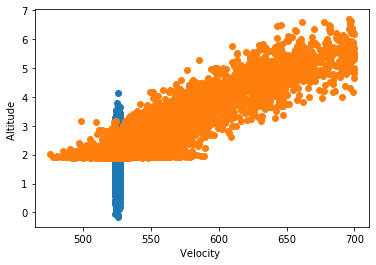

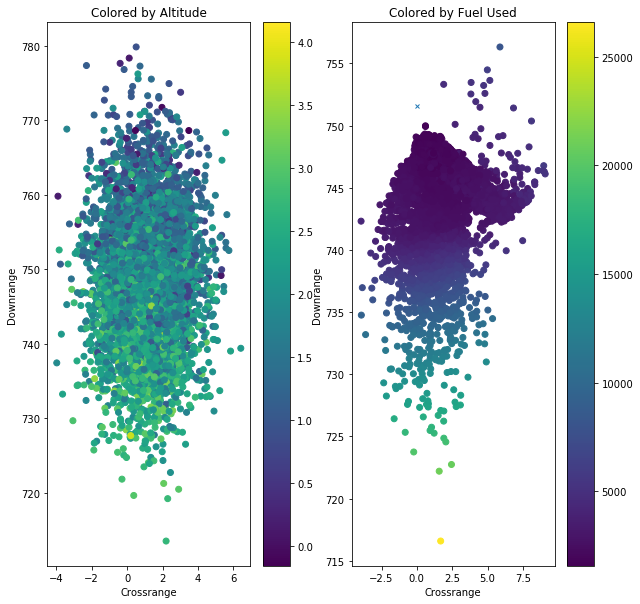

In [464]:
mc.plot()
mc.plot_srp()

In [465]:
apollo['K'] = 1

lateral = CrossrangeDeadband(500., 1500./6000, debug=False)
mc.control = controller(target, apollo, debug=False, one_sided=0, bank_lims=[5,85], lateral_guidance=lateral)

Vf = 527.5
mc.set_trigger(velocity_trigger(Vf))
mc.run(X0, save=False, stepsize=1)
mc.srp_trim(srpdata, target, vmax=700, hmin=1800)

 
Running Monte Carlo...
E0 15634314.6
Ef 0.0
energy depleted 
MC shape
(340, 7, 5000)
(339, 1, 5000)
(339, 2, 5000)
Terminal state shape: 
(5000, 7)
Monte Carlo complete, time elapsed = 57.7 s.


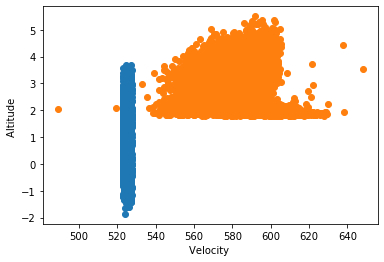

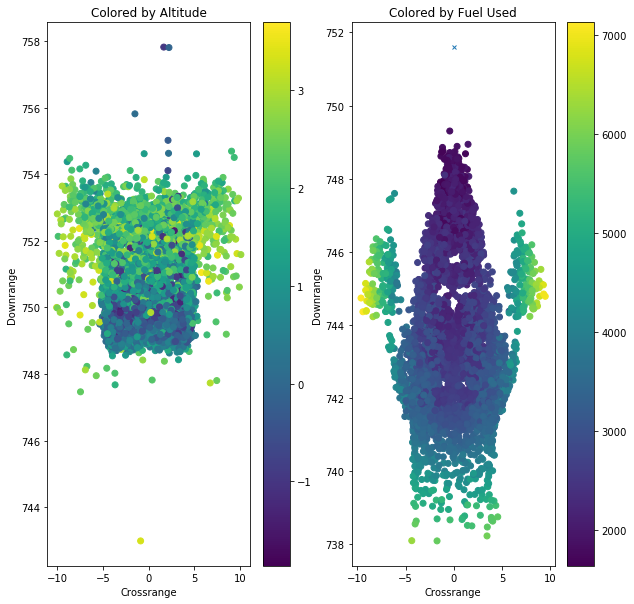

In [466]:
mc.plot()
mc.plot_srp()

In [411]:
th = 745/3397
ph = 0
psi = 0
# rtogo, crossrange = Planet().range(th, ph, psi, *target.coordinates(), km=False)
rtogo, crossrange = Planet().range(th-target.longitude, ph, psi, 0, 0, km=False)

print(rtogo)
# x = np.array(mc.mc_srp['ignition_state']).T
# plt.plot(x[1], x[0], 'o')

6604.406965070892


# Compute neighboring optimal solutions for different FPA to the same target 

In [ ]:
nominal = np.array([-2.84277273e-01,  2.21255345e-01,  7.11131800e-01,  2.84724663e+03]) # 40.7 deg bank 

efpa = nominal[0]
target.longitude = nominal[1]

bank = np.radians([20, 70])
vr = (1200, 4000)
fpa_delta = [-0.25, -0.125, -0.06, 0.06, 0.125, 0.25]

sol = [differential_evolution(param_objective, [bank, vr], args=(target, efpa+dfpa, False), disp=True, popsize=50) for dfpa in np.radians(fpa_delta)]

In [ ]:
sigma = [s.x[0] for s in sol ]
reverse = [s.x[1] for s in sol]
mf = [s.fun for s in sol]

plt.plot(fpa_delta, np.array(mf)-1592.6, 'o')
plt.plot(0,0,'o')
plt.xlabel("Delta FPA (deg)")
plt.ylabel("Delta SRP Fuel (kg)")

plt.figure()
plt.plot(fpa_delta, np.degrees(sigma), 'o')
plt.plot(0,np.degrees(nominal[2]),'o')
plt.xlabel("Delta FPA (deg)")
plt.ylabel("Optimal Bank Angle (deg)")

plt.figure()
plt.plot(fpa_delta, reverse, 'o')
plt.plot(0,nominal[3],'o')
plt.xlabel("Delta FPA (deg)")
plt.ylabel("Optimal Reversal (m/s)")

plt.show()

In [45]:
# Try smooth optimization?
x0 =  np.array([-2.84277273e-01,  2.21255345e-01,  7.11131800e-01,  2.84724663e+03]) # 40.7 deg bank 

target = Target(0, x0[1], altitude=0)
efpa = x0[0]
# print(param_objective(x0[2:], target, efpa, False))
sol = minimize(param_objective, x0[2:], args=(target, efpa, False), bounds=[np.radians([30, 50]), (2600, 3200)], method='SLSQP')

In [46]:
sol

     fun: 1607.3482346085366
     jac: array([-10694.1171875,      0.       ])
 message: 'Optimization terminated successfully.'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([7.11131962e-01, 2.84724663e+03])

## Second Order Accuracy of DA variables 

In [ ]:
x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))

Vf = 500 
dasim = Simulation(cycle=Cycle(1), output=True, use_da=True, **EntrySim(Vf=Vf), )

names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 'm']
order = 2
x0d = da.make(x0, names, order)
u = gdual_double(0., 'u', order)
# ref_profile = lambda **args: u

def ref_profile(velocity, **args):
    sigma = reversal_controller(np.radians(35), rev(35))(da.const(velocity))
    sigma = sigma + np.sign(sigma)*u
    return sigma 


res = dasim.run(x0d, [ref_profile])
traj = da.const(dasim.df.values, True)

In [ ]:
# xf = dasim.history[-1]
# for x in xf:
#     display(x)

In [ ]:
def get_diff(x, names, eval_pts):
    dx = x - da.const(x)
    
    dy = da.evaluate(dx, names, eval_pts)  # full second order deltas 
    J = da.jacobian(dx, names)
    dy1 = np.array([J.dot(e) for e in eval_pts])           # first order contribution
    p1 = np.abs(dy1/dy) # Fraction of the total delta due to first order terms. Could be >1 since the second order terms could be opposite in sign 
    return dy1, dy, p1

In [ ]:
N = 100000
D = cp.MvNormal(np.zeros((8,)), np.diag([5, 0.001, 0.001, 0.01, np.radians(0.02), np.radians(0.02), 0.001, np.radians(15)])**2)
deltas = D.sample(N, 'L').T
print(deltas.shape)

In [ ]:
dy, dy1, p1 = get_diff(xf[:3], names+['u'], deltas)


In [ ]:
for d, d1, px1, name, scale, unit in zip(dy.T, dy1.T, p1.T,names, [1/1000, 180/np.pi, 180/np.pi], ['km', 'deg','deg']):
    
#     plt.figure()
#     plt.hist([d1*scale, d*scale], bins = 50, histtype='step', label=['First Order', 'Total']) #
#     plt.title(f"Delta in final {name} ({unit})")
#     plt.legend()
    
    plt.figure()
    plt.scatter(d1*scale, d*scale, c=deltas[:,7]) #
    plt.colorbar()
    plt.plot(d1*scale, d1*scale, 'k--', linewidth=4)
    plt.title(f"Delta in final {name} ({unit})")
    plt.xlabel("First Order Estimate")
    plt.ylabel("Higher Order Estimate")
    plt.legend()


plt.show()

In [ ]:
def test_update(state, delta):
    from scipy.special import factorial 
    
    sf = dasim.df[state].iloc[-1]
    order = sf.order

#     display(sf)
    sd = sf.constant_cf + delta
    print("Target = {:.2f} ".format(sd))

    # Determine the required control correction by solving the linear and quadratic equations and test them for accuracy 
#     dfdu = sf.partial('u').constant_cf
#     df2 = sf.partial('u').partial('u').constant_cf
    
#     du_linear = delta/dfdu
#     coeff = [0.5*df2, dfdu, -delta]
    coeff = []
    for i in range(1, order+1):
        c = sf.extract_terms(i)
        for j in range(i):
            c = c.partial('u')
        coeff.append(c.constant_cf/factorial(i)) 
        
    coeff = coeff[::-1]
    coeff.append(-delta)
    print(coeff)
    du_linear = delta/coeff[-2]
    du_quad = np.roots(coeff)
    du_quad = du_quad[np.isreal(du_quad)] # keeps just the real roots
    
#     du_quad = du_quad[np.argmin(np.abs(du_quad))]
    print("Linear update = {:.2f}".format(np.degrees(du_linear)))
    print("Order {} updates = {}".format(order, np.degrees(du_quad)))
    
    sim = Simulation(cycle=Cycle(1), output=False, use_da=False, **EntrySim(Vf=Vf), )

    sol = []
    for du in [du_linear, *du_quad]:
        def ref_profile(velocity, **args):
            return np.radians(35)+du

        res = sim.run(x0, [ref_profile])
        sol.append(sim.df)
        print(sim.df[state].iloc[-1])
    return sol 

In [ ]:
dfs = test_update('longitude', np.degrees(10/3397))

In [ ]:
dfs = test_update('altitude', -3)


In [ ]:
du = dasim.df['altitude'].iloc[-1].subs('dr', 0.).subs('dV', 0).subs('dphi', 0).subs('dfpa', 0).subs('dm', 0)-dasim.df['altitude'].iloc[-1].constant_cf
du.subs('du', np.radians(8.70534037))

In [ ]:
## Range vs EFPA for a given vehicle config 

In [ ]:
N = 100
# lateral = HeadingDeadband(np.radians(0.5), np.radians(1)/5000)
# lateral = lambda state,cr: np.ones_like(cr)
# constant_guidance = ConstantBankWithLateralGuidance(np.radians(np.linspace(15, 45, N)), lateral)
constant_guidance = constant_controller(np.zeros(N))

mc = VMC()
mc.null_sample(N)
# mc.sample(N)

mc.control = constant_guidance
Vf = 600
mc.set_trigger(velocity_trigger(Vf))


x0 = InitialState(vehicle='heavy')
X0 = np.tile(x0[:,None], (1, N))
X0[4] = np.radians(np.linspace(-14.5, -25, N))
# print(x0[4] - X0[4])

mc.run(X0, save=False, stepsize=0.1, debug=False)

In [ ]:
mc.plot()


In [ ]:
plt.plot(np.degrees(X0[4]), mc.xf.T[1]*3397)
plt.xlabel('EFPA (deg)')
plt.ylabel('Terminal DR at Vf')

plt.figure()
plt.plot(np.degrees(X0[4]), mc.xf.T[0]/1000-3397)
plt.xlabel('EFPA (deg)')
plt.ylabel('Terminal Altitude at Vf')

In [ ]:
# How far has the vehicle flown by the time we reach 0.2g?

F = []
for aero,state in zip(mc.mca, mc.mc):
    D = aero.T[1]
    Sf = state[-1,1]*3397 # terminal DR in km 
    keep = D < 2
    S = state[keep,1]*3397
    F.append(S[-1]/Sf*100) 
#     print("S(D=2)/Sf = {:.2f}%".format(S[-1]/Sf*100))
plt.figure(1)
plt.plot(np.degrees(X0[4]), F)
plt.xlabel('EFPA (deg)')
plt.ylabel("Percentage of Range Flown at D=0.2g")

plt.figure(2)
plt.plot(mc.xf.T[1]*3397, F)
plt.xlabel('Total Range (km)')
plt.ylabel("Percentage of Range Flown at D=0.2g")
plt.show()

In [ ]:
mc.plot_trajectories()